### Objective: To evaluate recently trained models. 

I recently re-trained models for the purpose of evaluation. Models were trained with 5x10 CV. 
These were different datasets used for training. 
I used datasets with antibodies folded by Abody Builder 2 in all cases. 

### Load scripts

In [1]:
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itables import show
import plotly.express as px
from sklearn.metrics import root_mean_squared_error, r2_score, average_precision_score, roc_auc_score

from developability import data as data_
from developability.utils import ls
from tqdm.notebook import tqdm
from dill import load


## retina display
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

%load_ext autoreload
%autoreload 2

# paths 

data_path = Path(data_.__path__[0])

### Load Data 

In [2]:
training_path = data_path / 'train'
subset_path = training_path/'subsets'
today = '04-26-2024'
filename = training_path/f'train_{today}.parquet'
train = pd.read_parquet(filename)
train.head()

HeparinRRT_scaled  HeparinRRT>=1  HCDR1_APBS_pos  \
VIRMAB-MPK65-R1-19           0.943630              0      514.043614   
VIRMAB-MPK65-R1-21           0.944588              0      242.088930   
VIRMAB-MPK65-R1-27           0.944588              0      464.560335   
VIRMAB-MPK65-R1-24           0.945546              0      291.646471   
VIRMAB-MPK65-R1-22           0.945546              0      366.064822   

                    HCDR1_APBS_neg  HCDR1_APBS_net  HCDR2_APBS_pos  \
VIRMAB-MPK65-R1-19     -226.497693      287.545921      957.039160   
VIRMAB-MPK65-R1-21     -155.894361       86.194569     1144.556373   
VIRMAB-MPK65-R1-27      -58.598476      405.961859      865.244076   
VIRMAB-MPK65-R1-24     -147.543778      144.102693      820.741610   
VIRMAB-MPK65-R1-22     -108.704110      257.360713     1468.203155   

                    HCDR2_APBS_neg  HCDR2_APBS_net  HCDR3_APBS_pos  \
VIRMAB-MPK65-R1-19    -2774.632167    -1817.593007      474.052607   
VIRMAB-MPK65-R1-21    -2836.386774    -1691.830401      241.478273   
VIRMAB-MPK65-R1-27    -2724.851363    -1859.607288      423.496289   
VIRMAB-MPK65-R1-24    -2737.173248    -1916.431638      418.326279   
VIRMAB-MPK65-R1-22    -2324.547613     -856.344458      377.512744   

                    HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  \
VIRMAB-MPK65-R1-19   -11631.036286   -11156.983678    9187.473170   
VIRMAB-MPK65-R1-21   -11589.613907   -11348.135635    8455.836708   
VIRMAB-MPK65-R1-27   -11045.290265   -10621.793976    9069.096991   
VIRMAB-MPK65-R1-24   -11228.470281   -10810.144003    9326.261275   
VIRMAB-MPK65-R1-22   -11357.946167   -10980.433422    9703.616380   

                    HFR1_APBS_neg  HFR1_APBS_net  HFR2_APBS_pos  \
VIRMAB-MPK65-R1-19   -1570.692614    7616.780557    2185.065987   
VIRMAB-MPK65-R1-21   -1173.958997    7281.877712    2439.492207   
VIRMAB-MPK65-R1-27   -1690.993550    7378.103440    2381.159008   
VIRMAB-MPK65-R1-24   -1077.094244    8249.167032     373.585959   
VIRMAB-MPK65-R1-22   -1144.026385    8559.589996    2902.108756   

                    HFR2_APBS_neg  HFR2_APBS_net  HFR3_APBS_pos  \
VIRMAB-MPK65-R1-19    -203.909684    1981.156303    4158.978221   
VIRMAB-MPK65-R1-21    -316.636589    2122.855618    6257.033415   
VIRMAB-MPK65-R1-27    -213.788903    2167.370104    3713.731344   
VIRMAB-MPK65-R1-24    -904.631815    -531.045856    5655.615450   
VIRMAB-MPK65-R1-22    -244.230142    2657.878614    6786.561876   

                    HFR3_APBS_neg  HFR3_APBS_net  HFR4_APBS_pos  \
VIRMAB-MPK65-R1-19   -1759.852870    2399.125351     772.320449   
VIRMAB-MPK65-R1-21    -286.276976    5970.756439     257.495449   
VIRMAB-MPK65-R1-27   -2169.095956    1544.635388     808.693052   
VIRMAB-MPK65-R1-24    -298.212578    5357.402871     588.545738   
VIRMAB-MPK65-R1-22    -100.900932    6685.660944     761.538236   

                    HFR4_APBS_neg  HFR4_APBS_net  LCDR1_APBS_pos  \
VIRMAB-MPK65-R1-19    -949.248069    -176.927620      497.569119   
VIRMAB-MPK65-R1-21    -927.100073    -669.604624      600.417592   
VIRMAB-MPK65-R1-27   -1036.254124    -227.561072      548.447000   
VIRMAB-MPK65-R1-24    -885.861933    -297.316195      421.403946   
VIRMAB-MPK65-R1-22    -751.449461      10.088775      693.839926   

                    LCDR1_APBS_neg  LCDR1_APBS_net  LCDR2_APBS_pos  \
VIRMAB-MPK65-R1-19    -1568.220608    -1070.651489     2535.649024   
VIRMAB-MPK65-R1-21    -1436.307811     -835.890219     2255.001478   
VIRMAB-MPK65-R1-27    -1413.785404     -865.338404     2539.518784   
VIRMAB-MPK65-R1-24    -1570.191750    -1148.787804     2487.563063   
VIRMAB-MPK65-R1-22    -1396.639095     -702.799170     1805.883533   

                    LCDR2_APBS_neg  LCDR2_APBS_net  LCDR3_APBS_pos  \
VIRMAB-MPK65-R1-19     -371.314366     2164.334658      430.989836   
VIRMAB-MPK65-R1-21     -333.490586     1921.510893      413.984661   
VIRMAB-MPK65-R1-27     -305.141182     2234.377601      546.423271   
VIRMAB-MPK6

In [3]:
ls(training_path, True)


['antibody_descriptor_results.csv',
 'MPK190_descriptors_heparin_column_01-05-2024Train.pq',
 'MPK190_descriptors_05-03-2024.parquet',
 'MPK190_descriptors_heparin_column_01-05-2024.pq',
 'train_04-26-2024.parquet',
 'therapeutic_antibody_descriptor_results.parquet',
 'Multi_antibody_train_04-26-2024_with_project_names.parquet',
 'subsets',
 'MPK190_descriptors_heparin_column_01-05-2024Test.pq']

In [4]:
num_therapeutic_antibodies = len(pd.read_parquet(training_path/'therapeutic_antibody_descriptor_results.parquet'))
num_mpk190 = len(pd.read_parquet(training_path/'MPK190_descriptors_05-03-2024.parquet'))
num_multiple_ab_set = len(pd.read_parquet(training_path/'Multi_antibody_train_04-26-2024_with_project_names.parquet'))

print(f'There are {num_therapeutic_antibodies}, {num_mpk190}, {num_multiple_ab_set} antiodies in the therapeutic, MPK190, and multi-antibody sets repectively')

There are 128, 147, 715 antiodies in the therapeutic, MPK190, and multi-antibody sets repectively


In [5]:
pdbs_path = data_path/'pdbs'
experimental_data = data_path/'experimental_data'
antibody_df = pd.read_csv(experimental_data/'AntibodySequences.csv')
antibody_df.head()

Project               Name  \
0  FNI9v81   VIRMAB-FNI9-R1-4   
1  FNI9v81   VIRMAB-FNI9-R1-1   
2  FNI9v81  VIRMAB-FNI9-R1-23   
3  FNI9v81   VIRMAB-FNI9-R1-2   
4  FNI9v81  VIRMAB-FNI9-R1-25   

                                                  VH  \
0  QVQLVQSGAEVKRPGSSVKVSCKPSGGTFSNNVISWVRQAPGQGLE...   
1  QVHLVQSGAEVKEPGSSVTVSCKASGGTFNNQAISWVRQAPGQGLE...   
2  QVHLVQSGAEVKEPGSSVTVSCKASGGTFNNQAISWVRQAPGQGLE...   
3  QVHLVQSGAEVKEPGSSVTVSCKASGGTFNNQAISWVRQAPGQGLE...   
4  QVHLVQSGAEVKEPGSSVTVSCKASGGTFNNQAISWVRQAPGQGLE...   

                                                  VL  Heparin RRT  
0  EIVMTQSPATLSVSPGERATLSCRASQSVGSSLVWYQQKPGQAPRL...        1.105  
1  EIVMTQSPATLSLSSGERATLSCRASRSVSSNLAWYQQKPGQAPRL...        1.004  
2  EIVMTQSPATLSLSSGERATLSCRASRSVSSNLAWYQQKPGQAPRL...        0.966  
3  EIVMTQSPATLSLSSGERATLSCRASRSVSSNLAWYQQKPGQAPRL...        1.006  
4  EIVMTQSPATLSLSSGERATLSCRASRSVSSNLAWYQQKPGQAPRL...        0.956

In [6]:
project_counts = antibody_df['Project'].value_counts()
projects = project_counts.index.to_list()
project_counts

Project
MPK190     350
RSD5       149
MPK176     142
MPK65      138
MPK201     136
PIA38       89
FNI9v81     19
Name: count, dtype: int64

In [7]:
name_to_project = dict(zip(antibody_df['Name'], antibody_df['Project']))
train.insert(0, 'Project', train.index.map(name_to_project))

#### Functions for analysis 

In [8]:
def run_to_dataframe(runs): 
    info = {
        "run_id": [],
        "experiment_id": [],
        "status": [],
        "artifact_uri": [],
        "start_time": [],
        "end_time": [],
    }
    params, metrics, tags = ({}, {}, {})
    PARAM_NULL, METRIC_NULL, TAG_NULL = (None, np.nan, None)
    for i, run in enumerate(runs):
        info["run_id"].append(run.info.run_id)
        info["experiment_id"].append(run.info.experiment_id)
        info["status"].append(run.info.status)
        info["artifact_uri"].append(run.info.artifact_uri)
        info["start_time"].append(pd.to_datetime(run.info.start_time, unit="ms", utc=True))
        info["end_time"].append(pd.to_datetime(run.info.end_time, unit="ms", utc=True))

        # Params
        param_keys = set(params.keys())
        for key in param_keys:
            if key in run.data.params:
                params[key].append(run.data.params[key])
            else:
                params[key].append(PARAM_NULL)
        new_params = set(run.data.params.keys()) - param_keys
        for p in new_params:
            params[p] = [PARAM_NULL] * i  # Fill in null values for all previous runs
            params[p].append(run.data.params[p])

        # Metrics
        metric_keys = set(metrics.keys())
        for key in metric_keys:
            if key in run.data.metrics:
                metrics[key].append(run.data.metrics[key])
            else:
                metrics[key].append(METRIC_NULL)
        new_metrics = set(run.data.metrics.keys()) - metric_keys
        for m in new_metrics:
            metrics[m] = [METRIC_NULL] * i
            metrics[m].append(run.data.metrics[m])

        # Tags
        tag_keys = set(tags.keys())
        for key in tag_keys:
            if key in run.data.tags:
                tags[key].append(run.data.tags[key])
            else:
                tags[key].append(TAG_NULL)
        new_tags = set(run.data.tags.keys()) - tag_keys
        for t in new_tags:
            tags[t] = [TAG_NULL] * i
            tags[t].append(run.data.tags[t])

    data = {}
    data.update(info)
    for key, value in metrics.items():
        data["metrics." + key] = value
    for key, value in params.items():
        data["params." + key] = value
    for key, value in tags.items():
        data["tags." + key] = value
    return pd.DataFrame(data)


def get_columns(df, suffixes=None, prefixes=None, infixes=None, exclude=None): 

    def keep(col):
        for ex in exclude:
            if ex in col:
                return False

        return True
    
    cols = []
    if prefixes: 
        for prefix in prefixes:
            cols.extend([col for col in df.columns if col.startswith(prefix) and col not in cols])
    if infixes: 
        for infix in infixes: 
            cols.extend([col for col in df.columns if 'infix' in col and col not in cols])
    
    if suffixes: 
        for suffix in suffixes: 
            cols.extend([col for col in df.columns if col.endswith(suffix) and col not in cols])

    if exclude: 
        cols = [col for col in cols if keep(col)]
    

    df = df[cols]
    df = df.rename(columns = {col:col.split('.')[-1] for col in df.columns})
    return df
    


def extract_metadata_from_signature(model_path):
    
    """extracts the model target names from a model signature"""
    from mlflow.models import get_model_info

    def get_outputs(signature):
        return [output['name'] for output in signature.outputs.to_dict()]

    def get_inputs(signature):
        return [input['name'] for input in signature.inputs.to_dict()]

    signature = get_model_info(model_path).signature

    return get_inputs(signature), get_outputs(signature)



def get_data(exp_id, prefixes=None, select_columns = True): 
    if not prefixes: 
        prefixes = ['run_id', 'experiment_id', 'artifact_uri','tags.model', 'tags.feature_set', 'tags.Number_of_features', 'metrics.test']
        
    df = client.search_runs(experiment_ids = exp_id)
    df  = run_to_dataframe(df)
    if select_columns:
        df = get_columns( df, prefixes =prefixes, exclude =['sem'], infixes = ['model'])
    return df
    


### Connect to the client and list experiments 

In [9]:
client = MlflowClient(tracking_uri = 'http://127.0.0.1:5000')
experiments = client.search_experiments()
exp_name_ids = {exp.name:exp.experiment_id for exp in experiments}
exp_name_ids

{'HoldOutProjectClasification1': '636367620750585634',
 'HoldOutProjectRegression1': '811728697528313643',
 'MultipleAbsLOGORegression1': '513891332637349421',
 'MPK190Classification1': '530002079828370156',
 'MPK190Regression1': '314044571085263524',
 'TherapeuticAntibodiesClassification1': '390023385404897899',
 'TherapeuticAntibodiesRegression1': '629611838486583441',
 'MultipleParentalAntibodyClassificationExp1': '530984814487966949',
 'MultipleParentalAntibodyRegressionExp1': '231013285985979134',
 'Default': '0'}

### Therapeutic Antibodies. 
Below, we look at the performance of regression models on different feature sets. 

In [10]:
thera_reg_df = get_data('629611838486583441')
show(thera_reg_df)

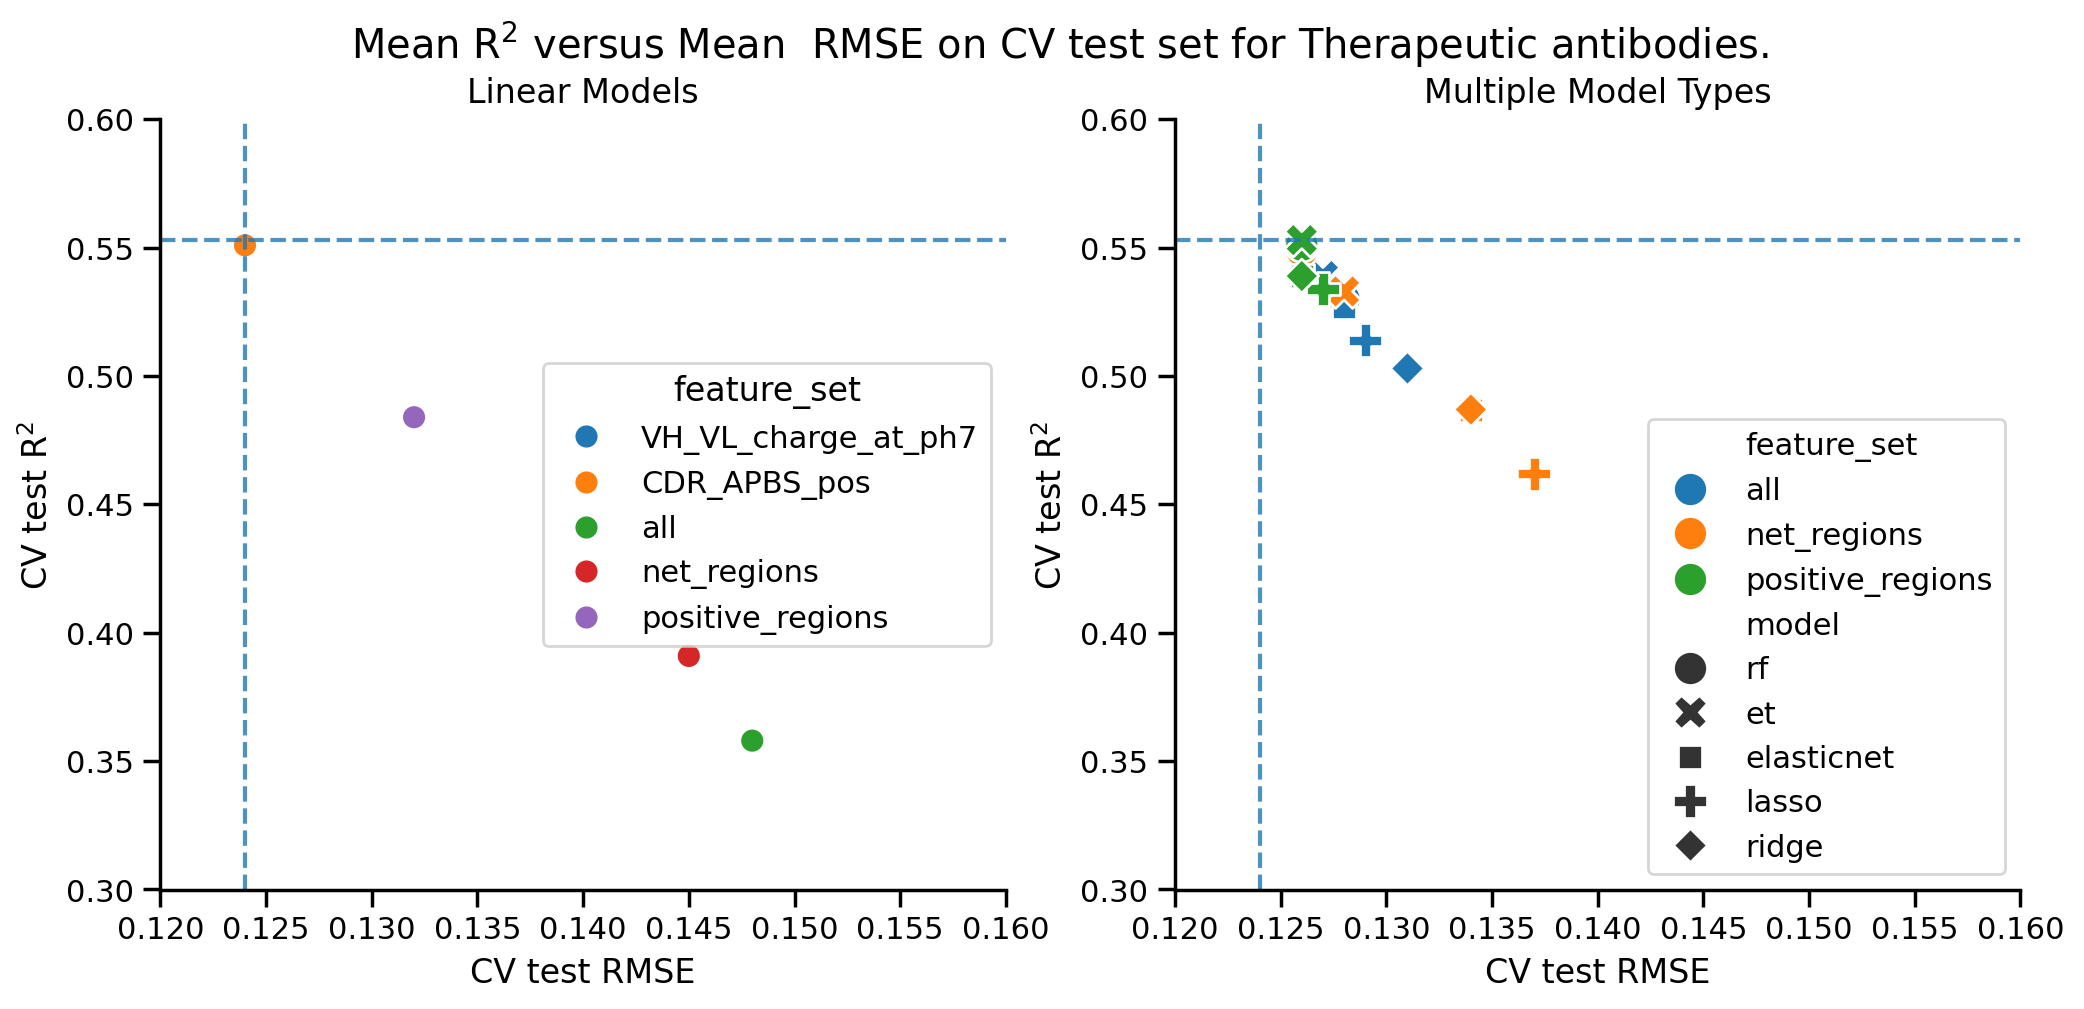

In [11]:
sns.set_context('notebook')
fig, axes = plt.subplots(1,2,figsize = (12,5))
size =150

data = thera_reg_df.loc[thera_reg_df['model']=='linear']
ax = sns.scatterplot(data, y = 'test_cv_r2',x='test_cv_rmse', hue = 'feature_set', ax = axes[0], s= size/2)
ax.axvline(0.124, linestyle='--', alpha = 0.8)
ax.axhline(0.553, linestyle='--', alpha = 0.8)

ax.set(xlabel = 'CV test RMSE', ylabel = r'CV test $\text{R}^2$', ylim =(0.3, 0.6), xlim=(0.12, 0.16), title='Linear Models')

sns.despine()

data = thera_reg_df.loc[thera_reg_df['model']!='linear']
ax = sns.scatterplot(data, y = 'test_cv_r2',x='test_cv_rmse', hue = 'feature_set', style = 'model', ax = axes[1], s = size)
ax.set(xlabel = 'CV test RMSE', ylabel = r'CV test $\text{R}^2$', ylim =(0.3, 0.6), xlim=(0.12, 0.16), title = 'Multiple Model Types')
ax.axvline(0.124, linestyle='--', alpha = 0.8)
ax.axhline(0.553, linestyle='--', alpha = 0.8)

fig.suptitle(r'Mean $\text{R}^2$ versus Mean  RMSE on CV test set for Therapeutic antibodies.')
sns.despine()


##### Commment

As can be seen, the best feature set consist of just one feature. 

### Classification for Therapeutic Antibodies 

In [12]:
thera_class_df = get_data('390023385404897899')
show(thera_class_df)

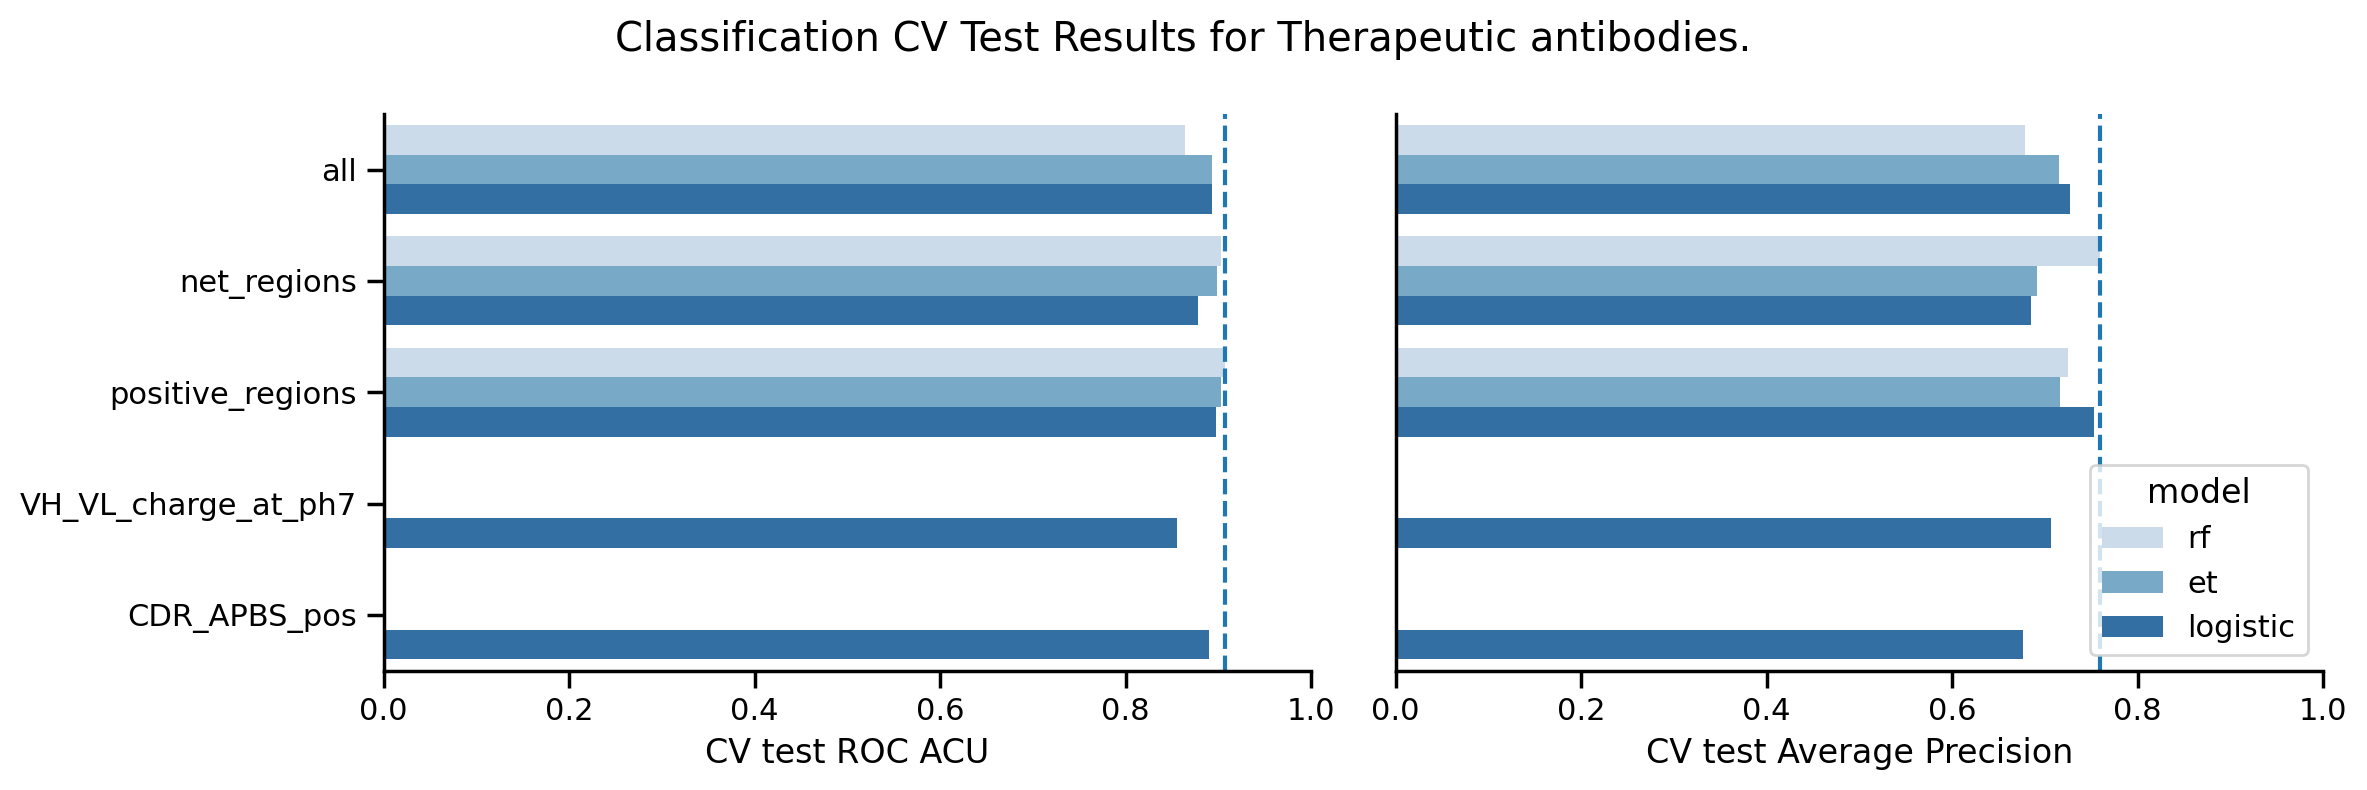

In [13]:
sns.set_context('notebook')
fig, axes = plt.subplots(1,2,figsize = (12,4))

data = thera_class_df
ax = sns.barplot(data, y='feature_set', x =  'test_cv_roc_auc', hue = 'model', ax = axes[0], palette='Blues', width = 0.8, legend=False)
ax.set(xlabel = 'CV test ROC ACU', ylabel = "", xlim = (0,1))
ax.axvline(0.907, linestyle = '--')
sns.despine()

ax = sns.barplot(data, y='feature_set', x =  'test_cv_average_precision', hue = 'model', ax = axes[1], palette='Blues', width = 0.8)
ax.set(xlabel = 'CV test Average Precision', ylabel = "", xlim = (0,1))
ax.get_yaxis().set_ticks([])
ax.axvline(0.759, linestyle = '--')
sns.despine()

fig.suptitle(r'Classification CV Test Results for Therapeutic antibodies.')

sns.despine()
plt.tight_layout()

### MPK190
This is the previous dataset. About 60 abs used to train. 

In [14]:
mpk190_regress_df =get_data('314044571085263524')
show(mpk190_regress_df)

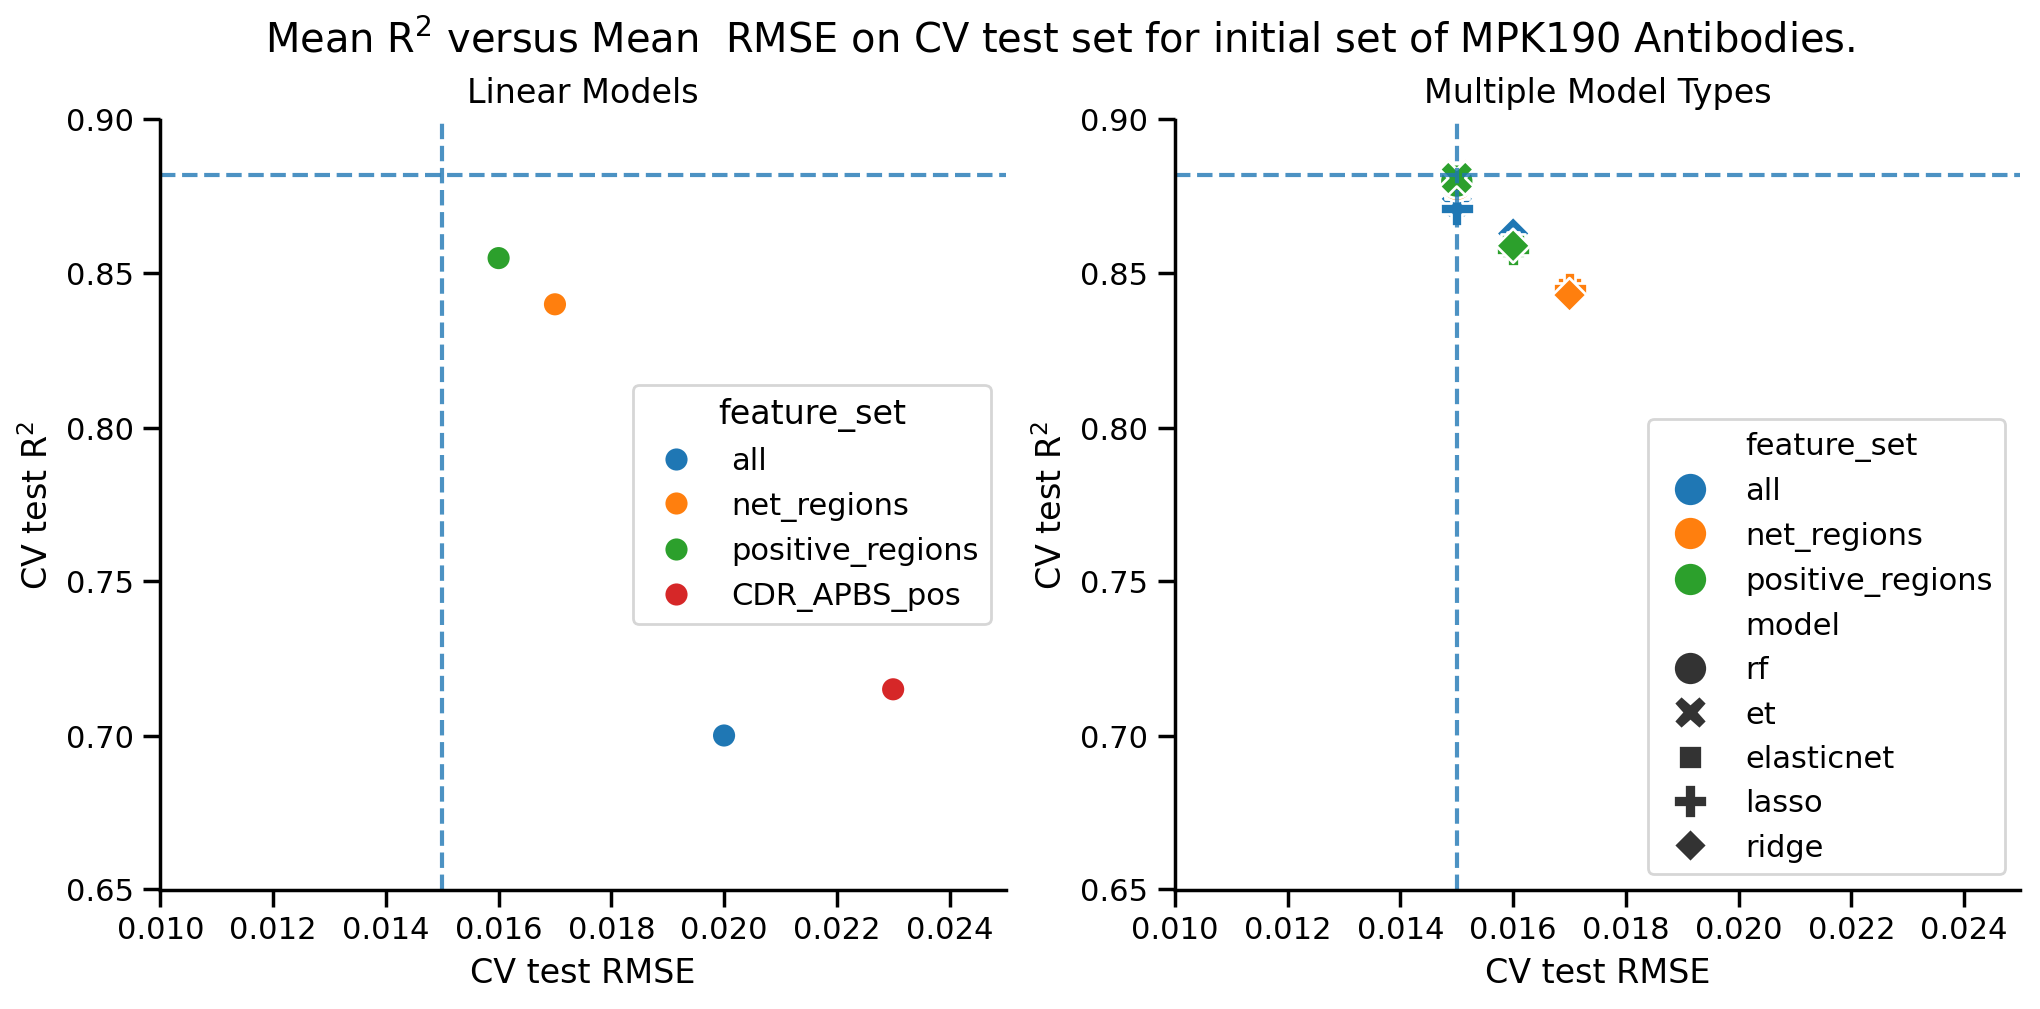

In [15]:
sns.set_context('notebook')
fig, axes = plt.subplots(1,2,figsize = (12,5))
size =150
xlim = (0.010, 0.025)
ylim =( 0.65, 0.9)

r2 = 0.882
rmse= 0.015

data = mpk190_regress_df.loc[mpk190_regress_df['model']=='linear']
ax = sns.scatterplot(data, y = 'test_cv_r2',x='test_cv_rmse', hue = 'feature_set', ax = axes[0], s= size/2)
ax.set(xlabel = 'CV test RMSE', ylabel = r'CV test $\text{R}^2$', xlim = xlim, ylim=ylim, title ='Linear Models')
ax.axvline(rmse, linestyle='--', alpha = 0.8)
ax.axhline(r2, linestyle='--', alpha = 0.8)

sns.despine()

data = mpk190_regress_df.loc[mpk190_regress_df['model']!='linear']
ax = sns.scatterplot(data, y = 'test_cv_r2',x='test_cv_rmse', hue = 'feature_set', style = 'model', ax = axes[1], s = size)
ax.axvline(rmse, linestyle='--', alpha = 0.8)
ax.axhline(r2, linestyle='--', alpha = 0.8)

ax.set(xlabel = 'CV test RMSE', ylabel = r'CV test $\text{R}^2$', xlim = xlim, ylim=ylim, title = 'Multiple Model Types')

fig.suptitle(r'Mean $\text{R}^2$ versus Mean  RMSE on CV test set for initial set of MPK190 Antibodies.')
sns.despine()

##### MPK190 classification 

In [16]:
mpk190_class_df =get_data('530002079828370156')
show(mpk190_class_df)

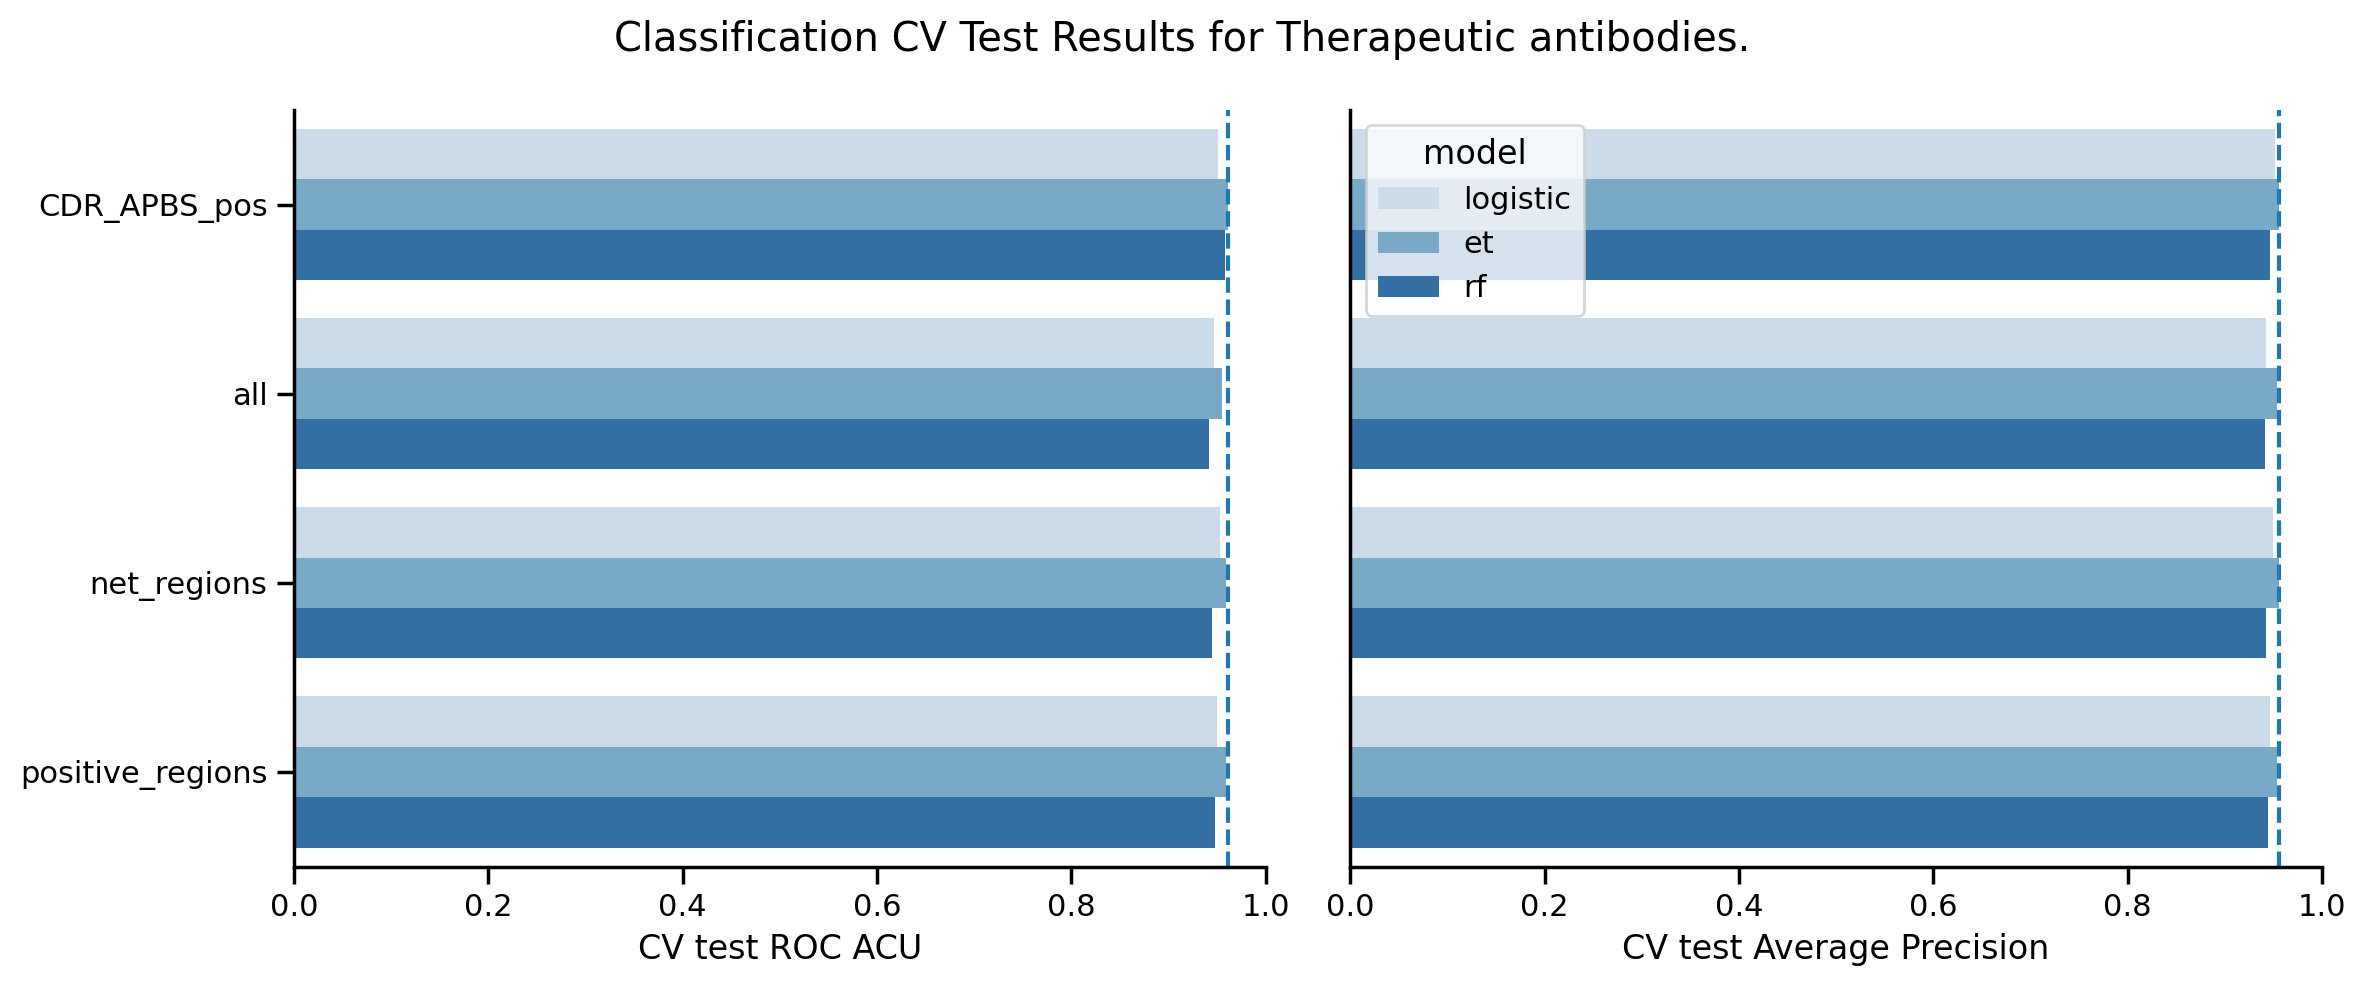

In [17]:
sns.set_context('notebook')
fig, axes = plt.subplots(1,2,figsize = (12,5))

data = mpk190_class_df
ax = sns.barplot(data, y='feature_set', x =  'test_cv_roc_auc', hue = 'model', ax = axes[0], palette='Blues', width = 0.8, legend=False)
ax.set(xlabel = 'CV test ROC ACU', ylabel = "", xlim = (0,1))
ax.axvline(0.961, linestyle = '--')
sns.despine()

ax = sns.barplot(data, y='feature_set', x =  'test_cv_average_precision', hue = 'model', ax = axes[1], palette='Blues', width = 0.8)
ax.set(xlabel = 'CV test Average Precision', ylabel = "", xlim = (0,1))
ax.get_yaxis().set_ticks([])
ax.axvline(0.956, linestyle = '--')
sns.despine()

fig.suptitle(r'Classification CV Test Results for Therapeutic antibodies.')

sns.despine()
plt.tight_layout()

### Multiple Projects

I analyzed the data from multiple projects. I used 6 data from 6 projects. The heparin RRT was measured in house. Joseph provided a scaling factor comparing to a marker. I saved the model results. 

In [18]:
dill_file = subset_path/'regression_resutls.pkl'
with open(dill_file, 'rb') as f: 
    regression_results = load(f)

dill_file = subset_path/'classification_results.pkl'
with open(dill_file, 'rb') as f: 
    classification_results = load(f)

In [19]:
projects

['MPK190', 'RSD5', 'MPK176', 'MPK65', 'MPK201', 'PIA38', 'FNI9v81']

#### Functions for analysis

In [20]:
def has_number(s): 
    for c in s: 
        if c.isdigit():
            return True
        
    return False

columns = train.columns
feature_sets = {'positive_regions': [col for col in columns if col.endswith('pos') and has_number(col)],
                'net_regions': [col for col in columns if col.endswith('net') and has_number(col)], 
                'all': [col for col in columns if 'APBS' in col],
                'CDR_APBS_pos':['TOTAL_CDR_APBS_pos'] ,
                }



def predict(project, key, regression =True, model=None): 
    data = train.query('Project==@project')
    feature_set, model_name = key

    X = data[feature_sets[feature_set]]
        
    if regression: 
        if not model:

            model = regression_results[project][key]
        y_true = data['HeparinRRT_scaled']
        y_pred = model.predict(X)

    else: 
        if not model:
            
            model = classification_results[project][key]
        y_true = data['HeparinRRT>=1']
        y_pred = model.predict_proba(X)[:,1]

    return y_true, y_pred




def predict_and_score( project, key, regression = True):
    
    if regression: 
        model = regression_results[project][key]
    else: 
        model = classification_results[project][key]
        

    data = train.query('Project==@project')
    feature_set, model_name = key


    X = data[feature_sets[feature_set]]
    
    scores = dict(project = project, feature_set=feature_set, model_name =model_name, number_trained = len(train)-len(X))



    if regression: 
        
        y_true = data['HeparinRRT_scaled']
        y_pred = model.predict(X)
        rmse = root_mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        scores['rmse']=rmse
        scores['r2'] = r2


    else: 
        y_true = data['HeparinRRT>=1']
        y_pred = model.predict_proba(X)[:,1]
        try: 
            roc_auc = roc_auc_score(y_true, y_pred)
        except: 
            roc_auc = np.NaN

        try: 
            ap = average_precision_score(y_true, y_pred)
        except: 
            ap=np.NAN
        
        scores['roc_auc']=roc_auc
        scores['ap'] = ap
        scores['num_pos'] = y_true.sum()
        scores['num_neg'] = (y_true==False).sum()
    return scores

def load_model(loc):
    path = Path('/home/crivera/projects/developability/mlartifacts')/loc
    return mlflow.sklearn.load_model(path)

loc = '314044571085263524/cb829c9fe5d44711a9350acb3f6b1dda/artifacts/rf'

In [21]:
reg_results = []
projects =['MPK190', 'RSD5', 'MPK176', 'MPK65', 'MPK201', 'FNI9v81']
for project in projects: 
    for key in regression_results[project]: 
        reg_results.append(predict_and_score( project, key, regression = True))
        
reg_results = pd.DataFrame.from_records(reg_results) 

In [22]:
show(reg_results)

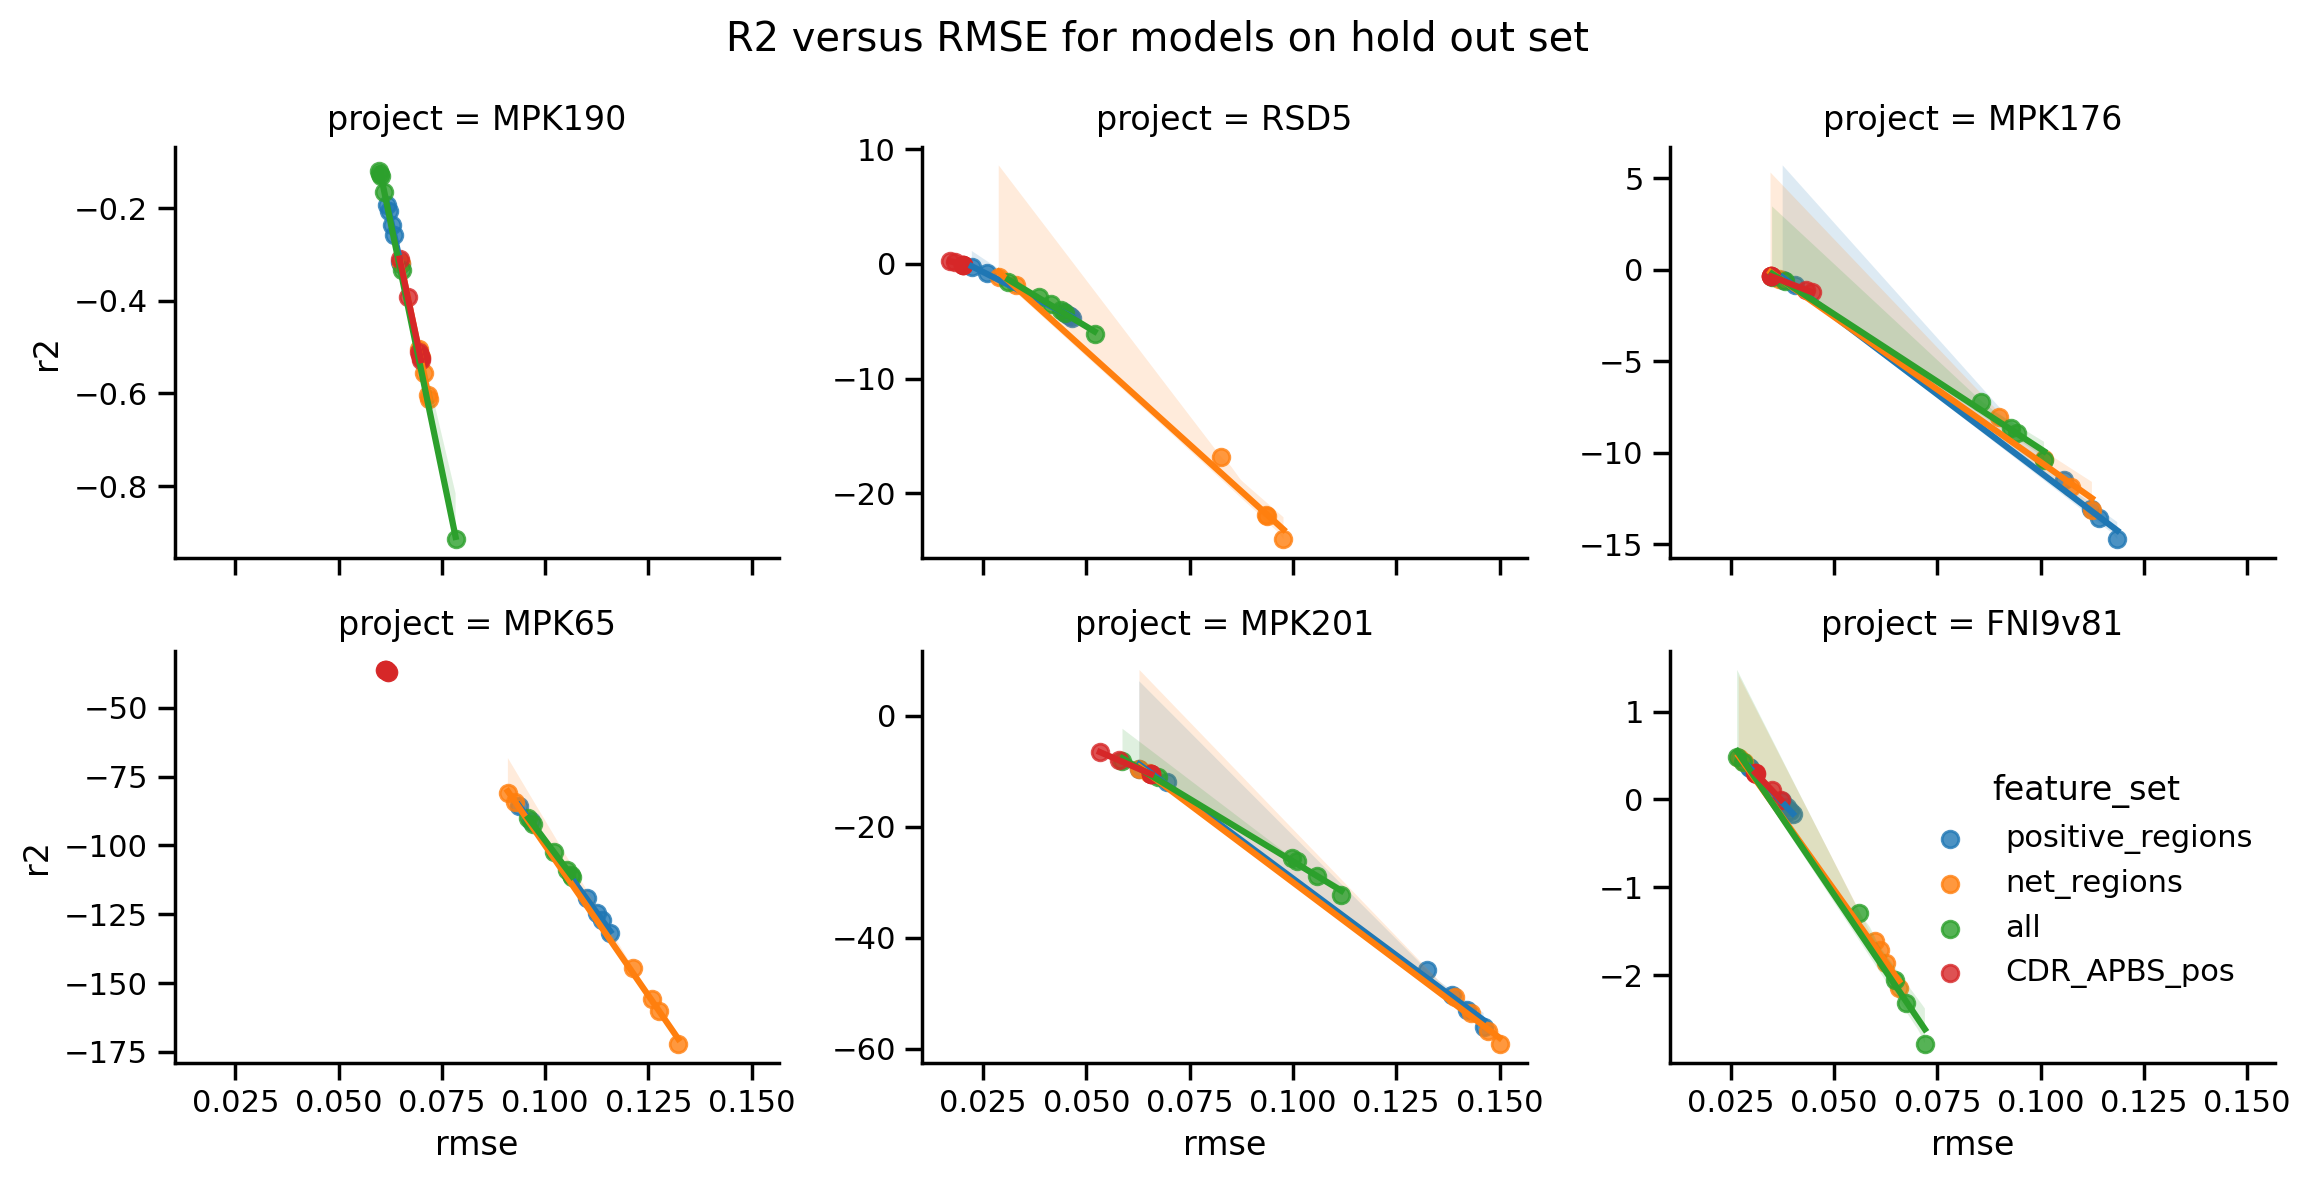

In [23]:
g= sns.lmplot(data = reg_results, x = 'rmse', y = 'r2', col ='project', facet_kws ={'sharex':True, 'sharey':False, 'legend_out':False}, hue = 'feature_set' , col_wrap=3, height= 3, aspect = 1.3)
sns.move_legend(g, "lower right", bbox_to_anchor=(.98, .15), frameon=False)
plt.gcf().suptitle('R2 versus RMSE for models on hold out set')
plt.tight_layout()

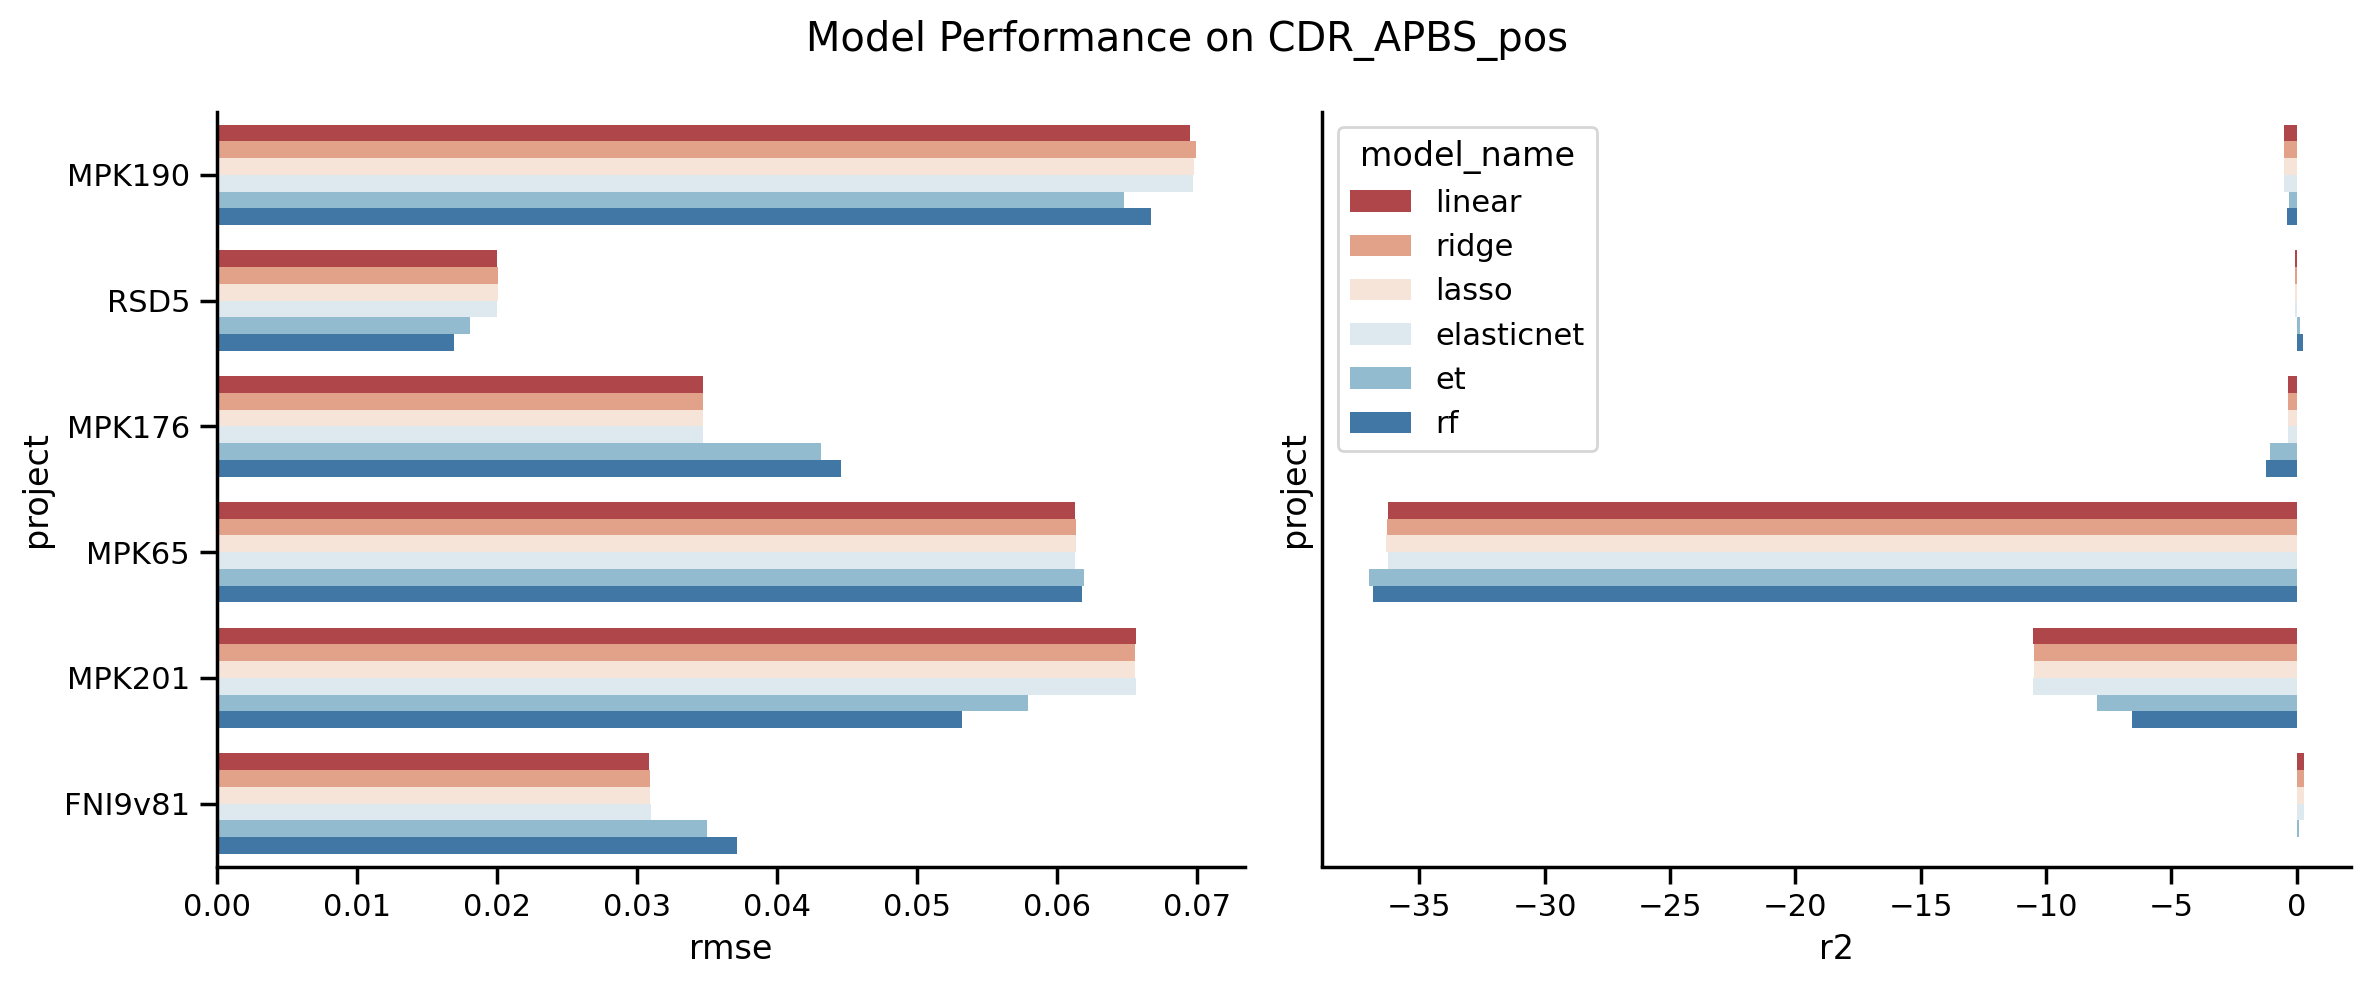

In [24]:
cdr_apbs_pos_ = reg_results.query('feature_set=="CDR_APBS_pos"')
sns.set_context('notebook')
fig, axes = plt.subplots(1,2,figsize = (12,5))

data = cdr_apbs_pos_
ax = sns.barplot(data, y='project', x =  'rmse', hue = 'model_name', ax = axes[0], palette='RdBu', width = 0.8, legend=False)
sns.despine()

ax = sns.barplot(data, y='project', x =  'r2', hue = 'model_name', ax = axes[1], palette='RdBu', width = 0.8)
ax.get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(r'Model Performance on CDR_APBS_pos')

sns.despine()
plt.tight_layout()


### Class 

In [25]:
class_results = []
projects =['MPK190', 'RSD5', 'MPK176', 'MPK65', 'MPK201', 'FNI9v81']
for project in projects: 
    for key in classification_results[project]: 
        class_results.append(predict_and_score( project, key, regression = False))
        
class_results = pd.DataFrame.from_records(class_results) 

/home/crivera/miniforge3/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/crivera/miniforge3/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/crivera/miniforge3/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/crivera/miniforge3/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/crivera/miniforge3/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all

In [26]:
show(class_results.dropna())

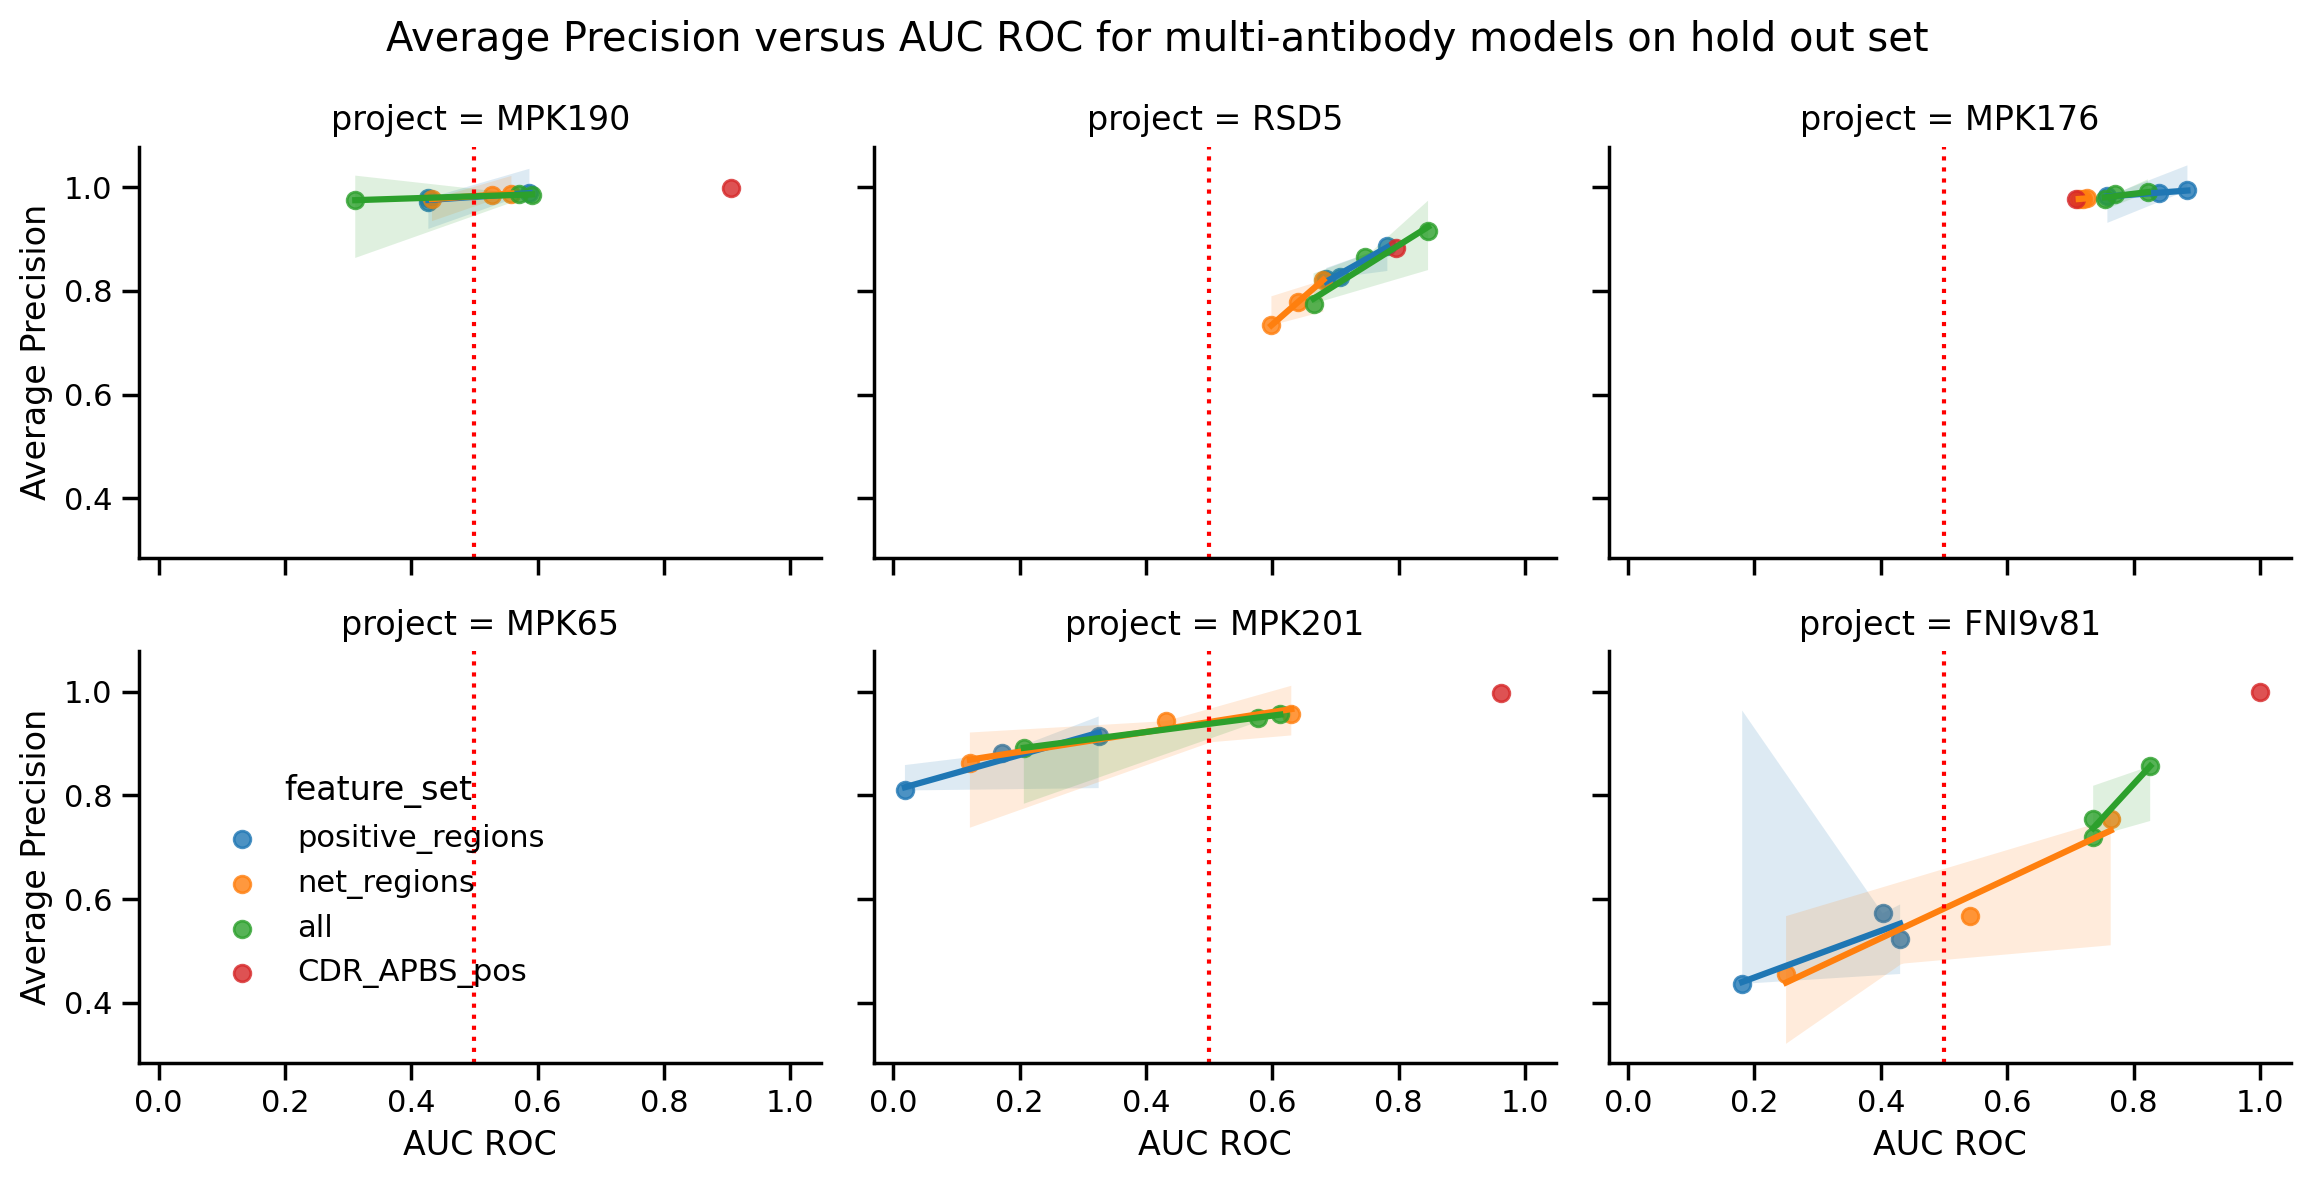

In [27]:
g= sns.lmplot(data = class_results, x = 'roc_auc', y = 'ap', col ='project', facet_kws ={'sharex':True, 'sharey':True, 'legend_out':False}, hue = 'feature_set' , col_wrap=3, height= 3, aspect = 1.3)
sns.move_legend(g, "lower right", bbox_to_anchor=(.25, .15), frameon=False)

for i, ax in enumerate(g.axes.flat):
    ax.axvline(x=0.5, color='r', linestyle=':')

    if i in [0,3]:
        ax.set(ylabel ='Average Precision')
    if i in [3, 4, 5]:
        ax.set(xlabel ='AUC ROC')

plt.gcf().suptitle('Average Precision versus AUC ROC for multi-antibody models on hold out set')
plt.tight_layout()

#### Comment

The models trained on all the data with one project are unreliable.  I am not sure why. 
This is either due to antibody specific effects (knowledge tranfer is unreliable), experimental error (i doubt) or maybe due to improper scaling (maybe). 
CDR_APBS_pos seems to be the mot reliable feature as models with this feature alone did okay. 


### Check on the performance of the models trained on the therapeutic antibodies and MPK190. 
I feel that these models will perform better.

In [28]:
thera_class_df.head()

run_id       experiment_id  \
0  a51f8379dffe4ae5b1b5c5757ceceecf  390023385404897899   
1  79271e2c173b434eadbf05bb2b8c4377  390023385404897899   
2  3b3af51f6bb241f1b85ed17d068875a5  390023385404897899   
3  c9b71b5be253479d914402e6af2aa768  390023385404897899   
4  4cfdf75c13ce4d4ca043d0edb547eb5e  390023385404897899   

                                        artifact_uri model       feature_set  \
0  mlflow-artifacts:/390023385404897899/a51f8379d...    rf               all   
1  mlflow-artifacts:/390023385404897899/79271e2c1...    et               all   
2  mlflow-artifacts:/390023385404897899/3b3af51f6...    rf       net_regions   
3  mlflow-artifacts:/390023385404897899/c9b71b5be...    et       net_regions   
4  mlflow-artifacts:/390023385404897899/4cfdf75c1...    rf  positive_regions   

  Number_of_features  test_cv_average_precision  test_cv_recall  \
0                 69                      0.679           0.433   
1                 69                      0.715           0.330   
2                 14                      0.759           0.550   
3                 14                      0.692           0.230   
4                 14                      0.725           0.500   

   test_cv_balanced_accuracy  test_cv_f1  test_cv_precision  test_cv_accuracy  \
0                      0.711       0.489              0.625             0.939   
1                      0.665       0.415              0.620             0.938   
2                      0.769       0.614              0.762             0.948   
3                      0.611       0.278              0.393             0.921   
4                      0.743       0.560              0.693             0.941   

   test_cv_roc_auc  
0            0.864  
1            0.893  
2            0.903  
3            0.899  
4            0.907

In [29]:
def get_model(df, model, feature_set): 
    row = df.query('model==@model and feature_set==@feature_set').iloc[0,:]
    uri = row.artifact_uri.replace('mlflow-artifacts:/' ,'')
    path = Path('/home/crivera/projects/developability/mlartifacts')/uri/model
    #print(path)
    model = mlflow.sklearn.load_model(path)
    return model

def predict_with_model(model, feature_set, df, regression =True): 
    model_name = model
    model = get_model(df, model, feature_set)
    features = feature_sets[feature_set]
    X = train[features]

    if regression: 
        y_true = train['HeparinRRT_scaled']
        y_pred = model.predict(X)
    else:
        y_true = train['HeparinRRT>=1']
        y_pred = model.predict_proba(X)

    df = pd.DataFrame(dict(Project = train['Project'], y_true=y_true, y_pred = y_pred), index = train.index)
    df['residual'] = df['y_pred']-df['y_true']
    df.insert(0,'model', model_name)
    df.insert(0, 'feature_set', feature_set)
    return df


def score_regression(results, model_name='lm_apbs_thera'):

    r2_global = r2_score(results['y_true'], results['y_pred'])
    rmse_global = root_mean_squared_error(results['y_true'], results['y_pred'])
    pearson_global= results[['y_true', 'y_pred']].corr().iloc[1,0]
    spearman_global = results[['y_true', 'y_pred']].corr(method ='spearman').iloc[1,0]

    rmses = results.groupby('Project')[['y_true', 'y_pred']].apply(lambda x: root_mean_squared_error(x['y_true'], x['y_pred']))
    r2s = rmses = results.groupby('Project')[['y_true', 'y_pred']].apply(lambda x: r2_score(x['y_true'], x['y_pred']))
    pearsons = results.groupby('Project')[['y_true', 'y_pred']].apply(lambda x: x.corr().iloc[1,0])
    spearmans = results.groupby('Project')[['y_true', 'y_pred']].apply(lambda x: x.corr(method ='spearman').iloc[1,0])


    df = pd.concat([rmses,r2s, pearsons, spearmans], axis = 1)
    df.columns = ['RMSE', 'R2', 'Pearson Corr', 'Spearman Corr']
    
    df.loc['All'] = [rmse_global, r2_global, pearson_global, spearman_global]
    df = df.reset_index()
    df.insert(0, 'model', model_name)
    
    return df.round(2)


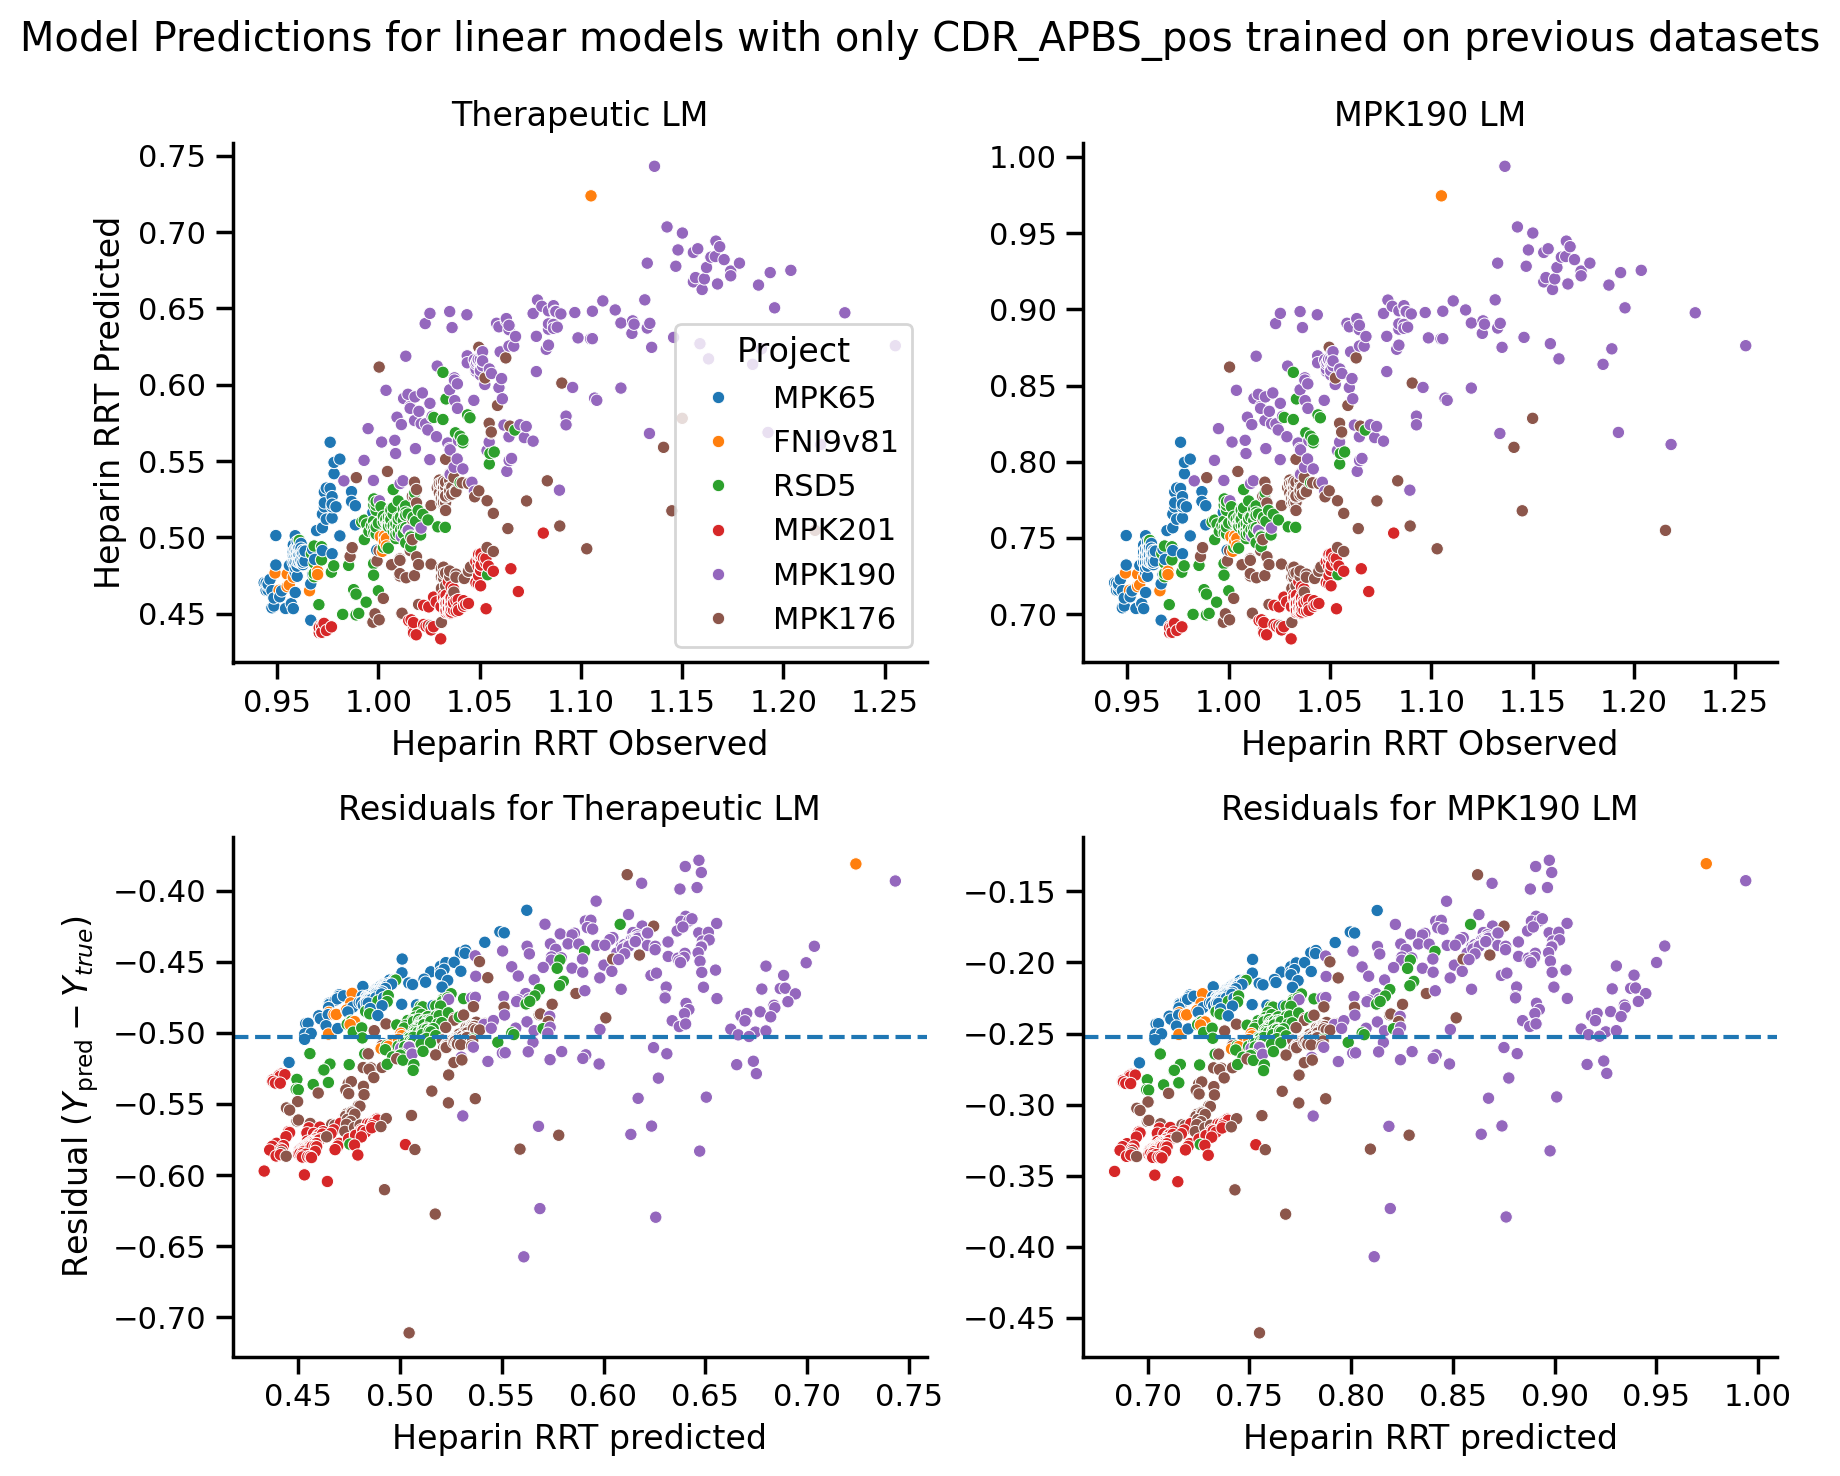

In [30]:
res = predict_with_model('linear', 'CDR_APBS_pos', thera_reg_df)
res2 = predict_with_model('linear', 'CDR_APBS_pos', mpk190_regress_df)
combined = res.merge(res2,left_index=True, right_index = True)
combined['diff'] = combined['y_pred_y']-combined['y_pred_x']

w = 3
size = 20
fig, axes = plt.subplots(2,2, figsize = (w*3, w*2.5))
axes = np.ravel(axes)


ax = sns.scatterplot(data = res, x='y_true', y='y_pred', hue = 'Project', ax=axes[0], s= size)
ax.set(xlabel ='Heparin RRT Observed', ylabel='Heparin RRT Predicted', title = 'Therapeutic LM')

ax=sns.scatterplot(data = res2, x='y_true', y='y_pred', hue = 'Project', ax = axes[1], s=size, legend=False)
ax.set(xlabel ='Heparin RRT Observed', title = 'MPK190 LM', ylabel = '')


ax=sns.scatterplot(data = res, x='y_pred', y='residual', hue = 'Project', ax = axes[2], s=size,legend=False)
ax.set(xlabel ='Heparin RRT predicted', title = 'Residuals for Therapeutic LM', ylabel = r'Residual ($Y_{\text{pred}}-Y_{{true}}$)')
ax.axhline(res['residual'].mean(), linestyle='--')

ax=sns.scatterplot(data = res2, x='y_pred', y='residual', hue = 'Project', ax = axes[3], s=size,legend=False)
ax.set(xlabel ='Heparin RRT predicted', title = 'Residuals for MPK190 LM', ylabel = '')
ax.axhline(res2['residual'].mean(), linestyle='--')

fig.suptitle("Model Predictions for linear models with only CDR_APBS_pos trained on previous datasets")

sns.despine()

plt.tight_layout()

In [31]:
pd.concat([score_regression(res),score_regression(res2, 'lm_apbs_MPK190')])

model  Project     RMSE       R2  Pearson Corr  Spearman Corr
0   lm_apbs_thera  FNI9v81  -173.87  -173.87          0.91           0.80
1   lm_apbs_thera   MPK176  -303.74  -303.74          0.32           0.35
2   lm_apbs_thera   MPK190   -67.69   -67.69          0.64           0.68
3   lm_apbs_thera   MPK201  -880.51  -880.51          0.71           0.71
4   lm_apbs_thera    MPK65 -2204.89 -2204.89          0.73           0.62
5   lm_apbs_thera     RSD5  -648.51  -648.51          0.71           0.59
6   lm_apbs_thera      All     0.51   -93.77          0.65           0.48
0  lm_apbs_MPK190  FNI9v81   -41.03   -41.03          0.91           0.80
1  lm_apbs_MPK190   MPK176   -82.38   -82.38          0.32           0.35
2  lm_apbs_MPK190   MPK190   -14.24   -14.24          0.64           0.68
3  lm_apbs_MPK190   MPK201  -279.99  -279.99          0.71           0.71
4  lm_apbs_MPK190    MPK65  -486.83  -486.83          0.73           0.62
5  lm_apbs_MPK190     RSD5  -160.00  -160.00          0.71           0.59
6  lm_apbs_MPK190      All     0.26   -23.59          0.65           0.48

### Try with the best 3 models by R2 for each. 

This is with the RMSE from CV_test

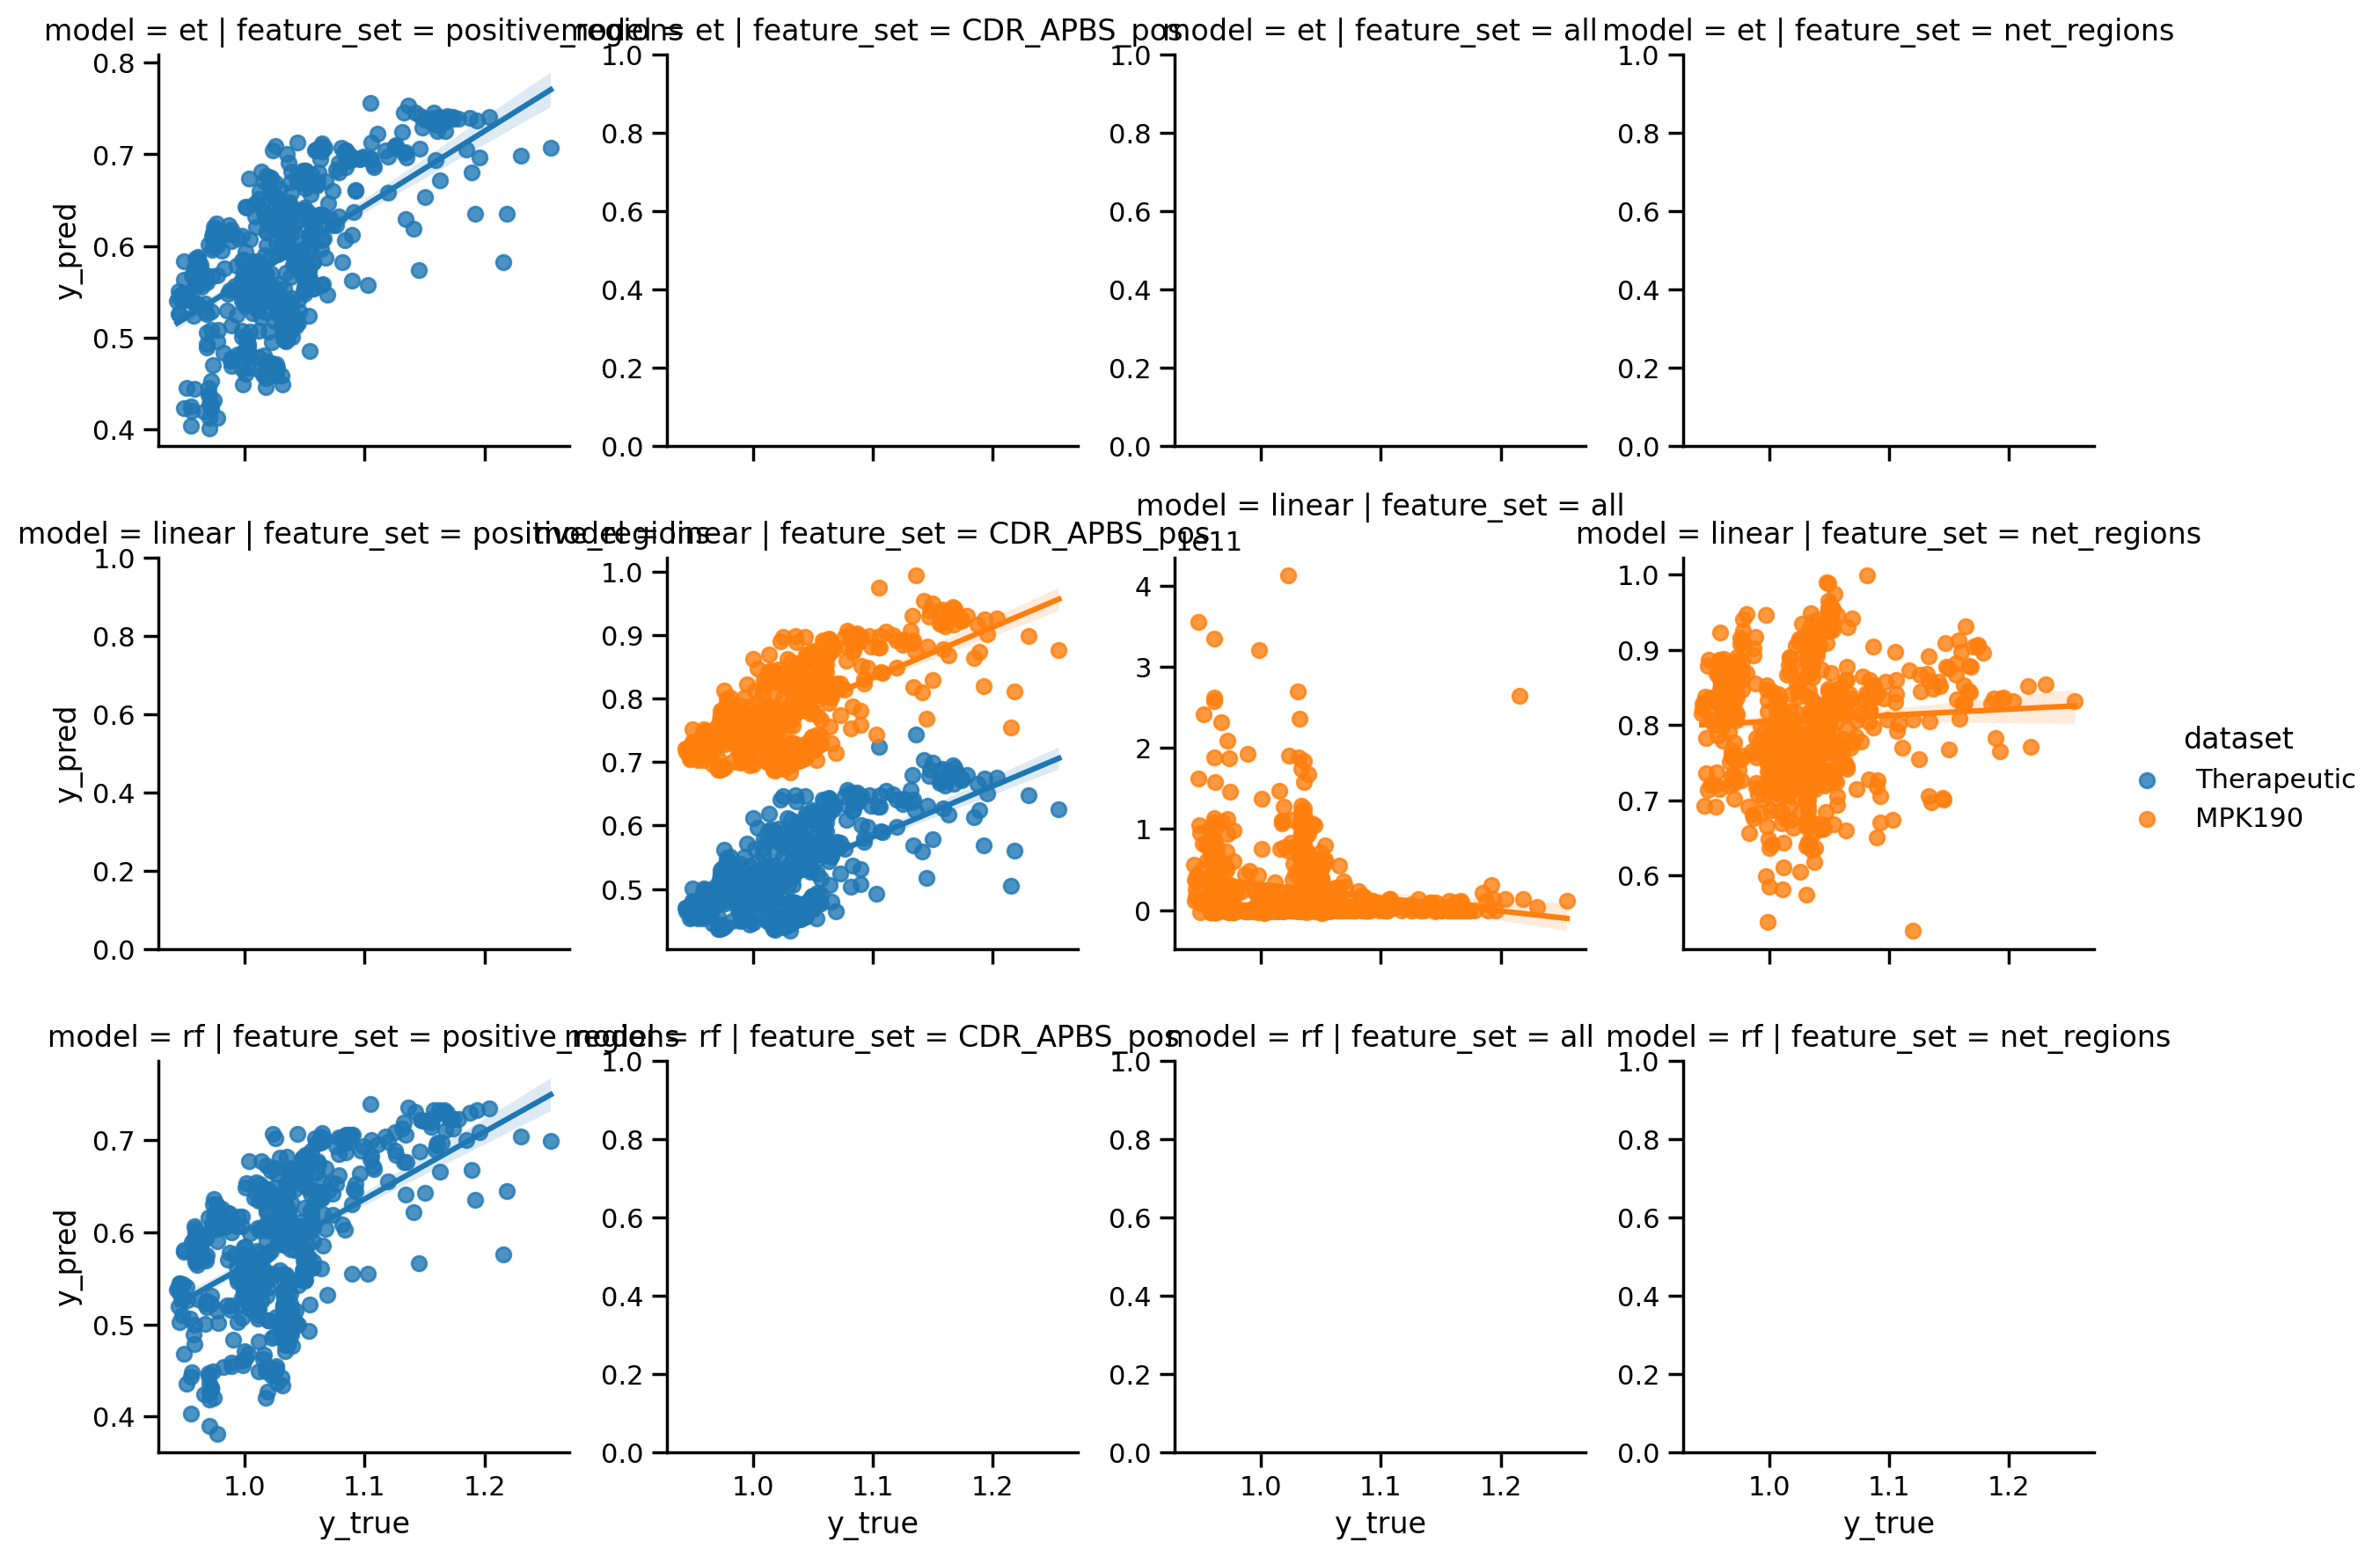

In [32]:
best3_thera= thera_reg_df.query('feature_set!="VH_VL_charge_at_ph7"').sort_values('test_cv_r2', ascending = False).head(3)
best3_mpk190= mpk190_regress_df.sort_values('test_cv_r2').head(3)

best3 = pd.concat([best3_thera, best3_mpk190])
best3['dataset'] = ['Therapeutic']*3 + ['MPK190']*3


results_df=[]
for _, row in best3.iterrows(): 
    dataset=row.dataset
    model = row.model
    feature_set=row.feature_set
    if dataset =='Therapeutic':
        df= thera_reg_df
    else: 
        df = mpk190_regress_df

    r = predict_with_model(model, feature_set, df, regression =True)
    r.insert( 0,'dataset',  dataset)

    results_df.append(r)

best_df = pd.concat(results_df)


sns.lmplot(best_df, x='y_true', y='y_pred', col = 'feature_set', row = 'model', hue='dataset', facet_kws=dict(sharex=True, sharey=False), height=3)

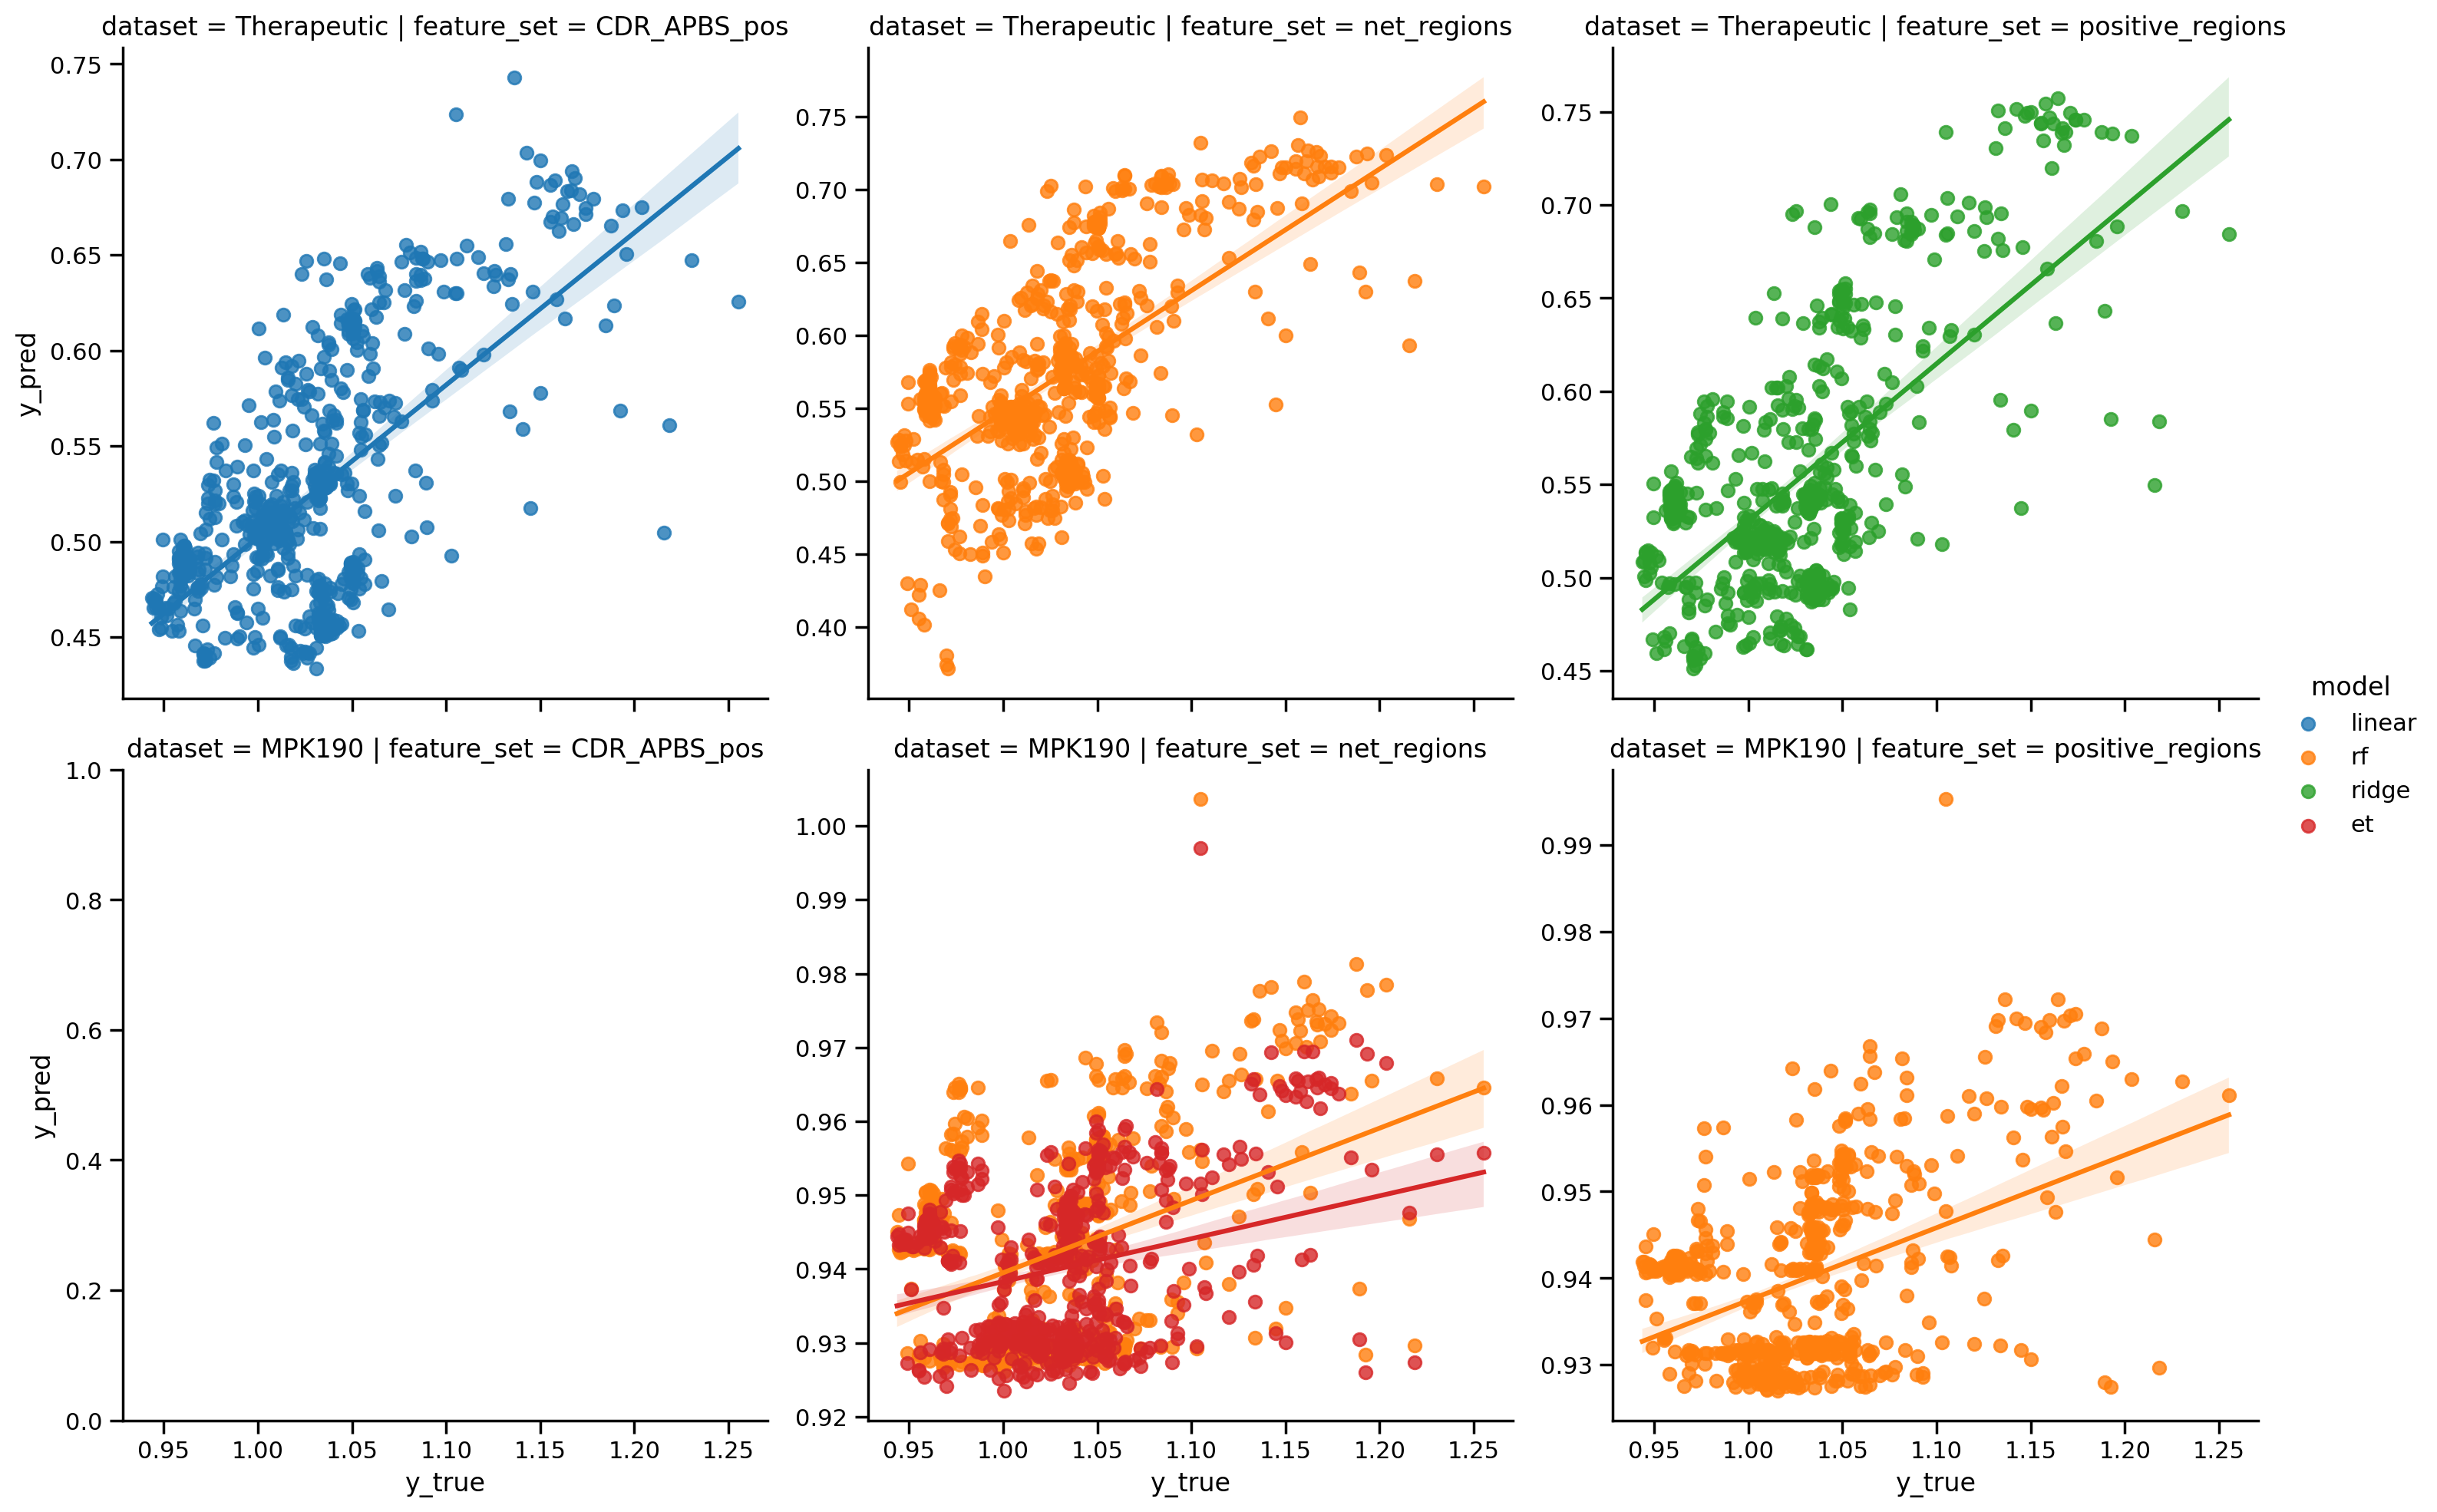

In [33]:
best3_thera= thera_reg_df.query('feature_set!="VH_VL_charge_at_ph7"').sort_values('test_cv_rmse').head(3)
keep = (mpk190_regress_df['model']!='elasticnet') & (mpk190_regress_df['feature_set']!='all') 
best3_mpk190= mpk190_regress_df.loc[keep].sort_values('test_cv_rmse').head(3)

best3 = pd.concat([best3_thera, best3_mpk190])
best3['dataset'] = ['Therapeutic']*3 + ['MPK190']*3


results_df=[]
for _, row in best3.iterrows(): 
    dataset=row.dataset
    model = row.model
    feature_set=row.feature_set
    if dataset =='Therapeutic':
        df= thera_reg_df
    else: 
        df = mpk190_regress_df

    r = predict_with_model(model, feature_set, df, regression =True)
    r.insert( 0,'dataset',  dataset)

    results_df.append(r)

best_df = pd.concat(results_df)


sns.lmplot(best_df, x='y_true', y='y_pred', col = 'feature_set', row='dataset', hue='model', facet_kws=dict(sharex=True, sharey=False))

### Restrict to looking at only Lasso not using all

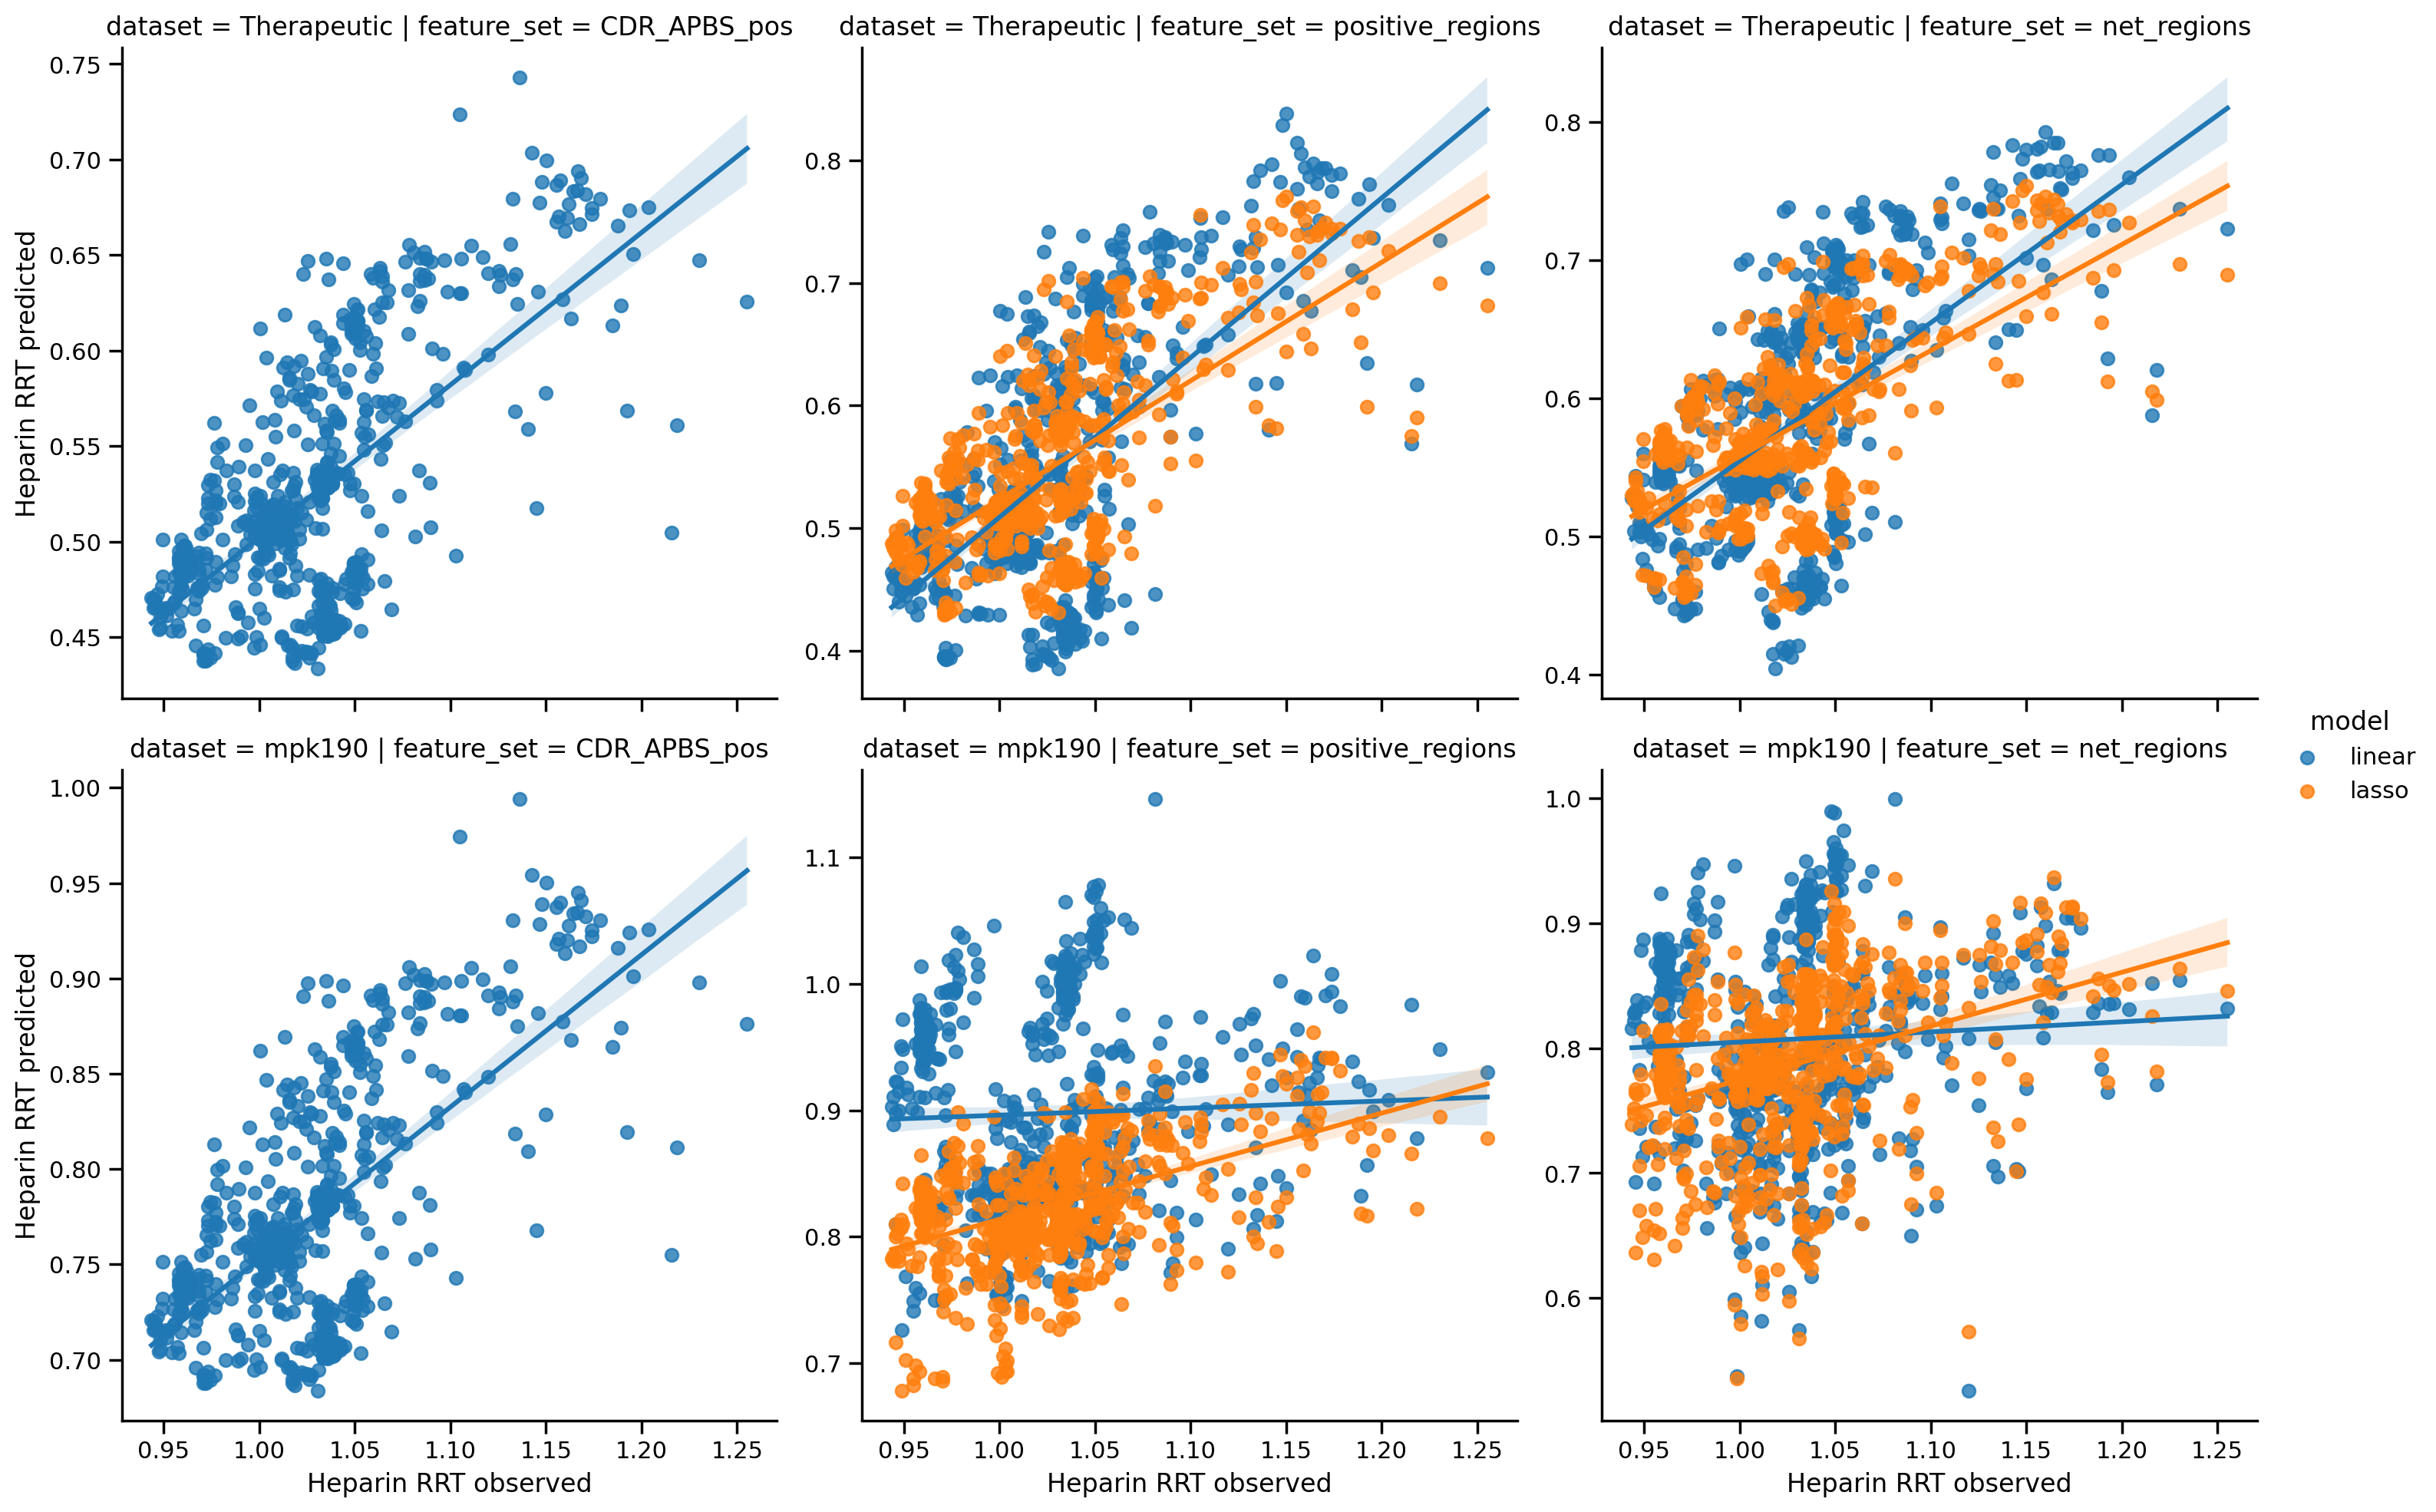

In [34]:
best5_thera= thera_reg_df.query('feature_set!="VH_VL_charge_at_ph7"  and feature_set!="all" and model in ["lasso", "linear"]').sort_values('test_cv_rmse').head()
best5_thera.insert(0, 'dataset', 'Therapeutic')

best5_mpk190= mpk190_regress_df.query('feature_set!="all" and model in ["lasso", "linear"]').loc[keep].sort_values('test_cv_rmse').head()
best5_mpk190.insert(0, 'dataset', 'mpk190')
best5 = pd.concat([best5_thera, best5_mpk190])



results_df=[]
for _, row in best5.iterrows(): 
    dataset=row.dataset
    model = row.model
    feature_set=row.feature_set
    if dataset =='Therapeutic':
        df= thera_reg_df
    else: 
        df = mpk190_regress_df

    r = predict_with_model(model, feature_set, df, regression =True)
    r.insert( 0,'dataset',  dataset)

    results_df.append(r)

best_df = pd.concat(results_df)


g = sns.lmplot(best_df, x='y_true', y='y_pred', col = 'feature_set', row='dataset', hue='model', facet_kws=dict(sharex=True, sharey=False))
for i, ax in enumerate(g.axes.flat):
    if i in [0, 3]: 
        ax.set(ylabel ='Heparin RRT predicted')
    if i in [3,4,5]:
        ax.set(xlabel ='Heparin RRT observed')


In [35]:
scores = best_df.groupby(['dataset', 'feature_set', 'model'])[['Project', 'y_true', 'y_pred']].apply(score_regression).drop(columns=['model'])
show(scores)

In [36]:
pearson_df = scores.reset_index().pivot(index =['dataset' , 'feature_set', 'model' ], values = 'Pearson Corr', columns = 'Project' )
spearman_df = scores.reset_index().pivot(index =['dataset' , 'feature_set', 'model' ], values = 'Spearman Corr', columns = 'Project' )

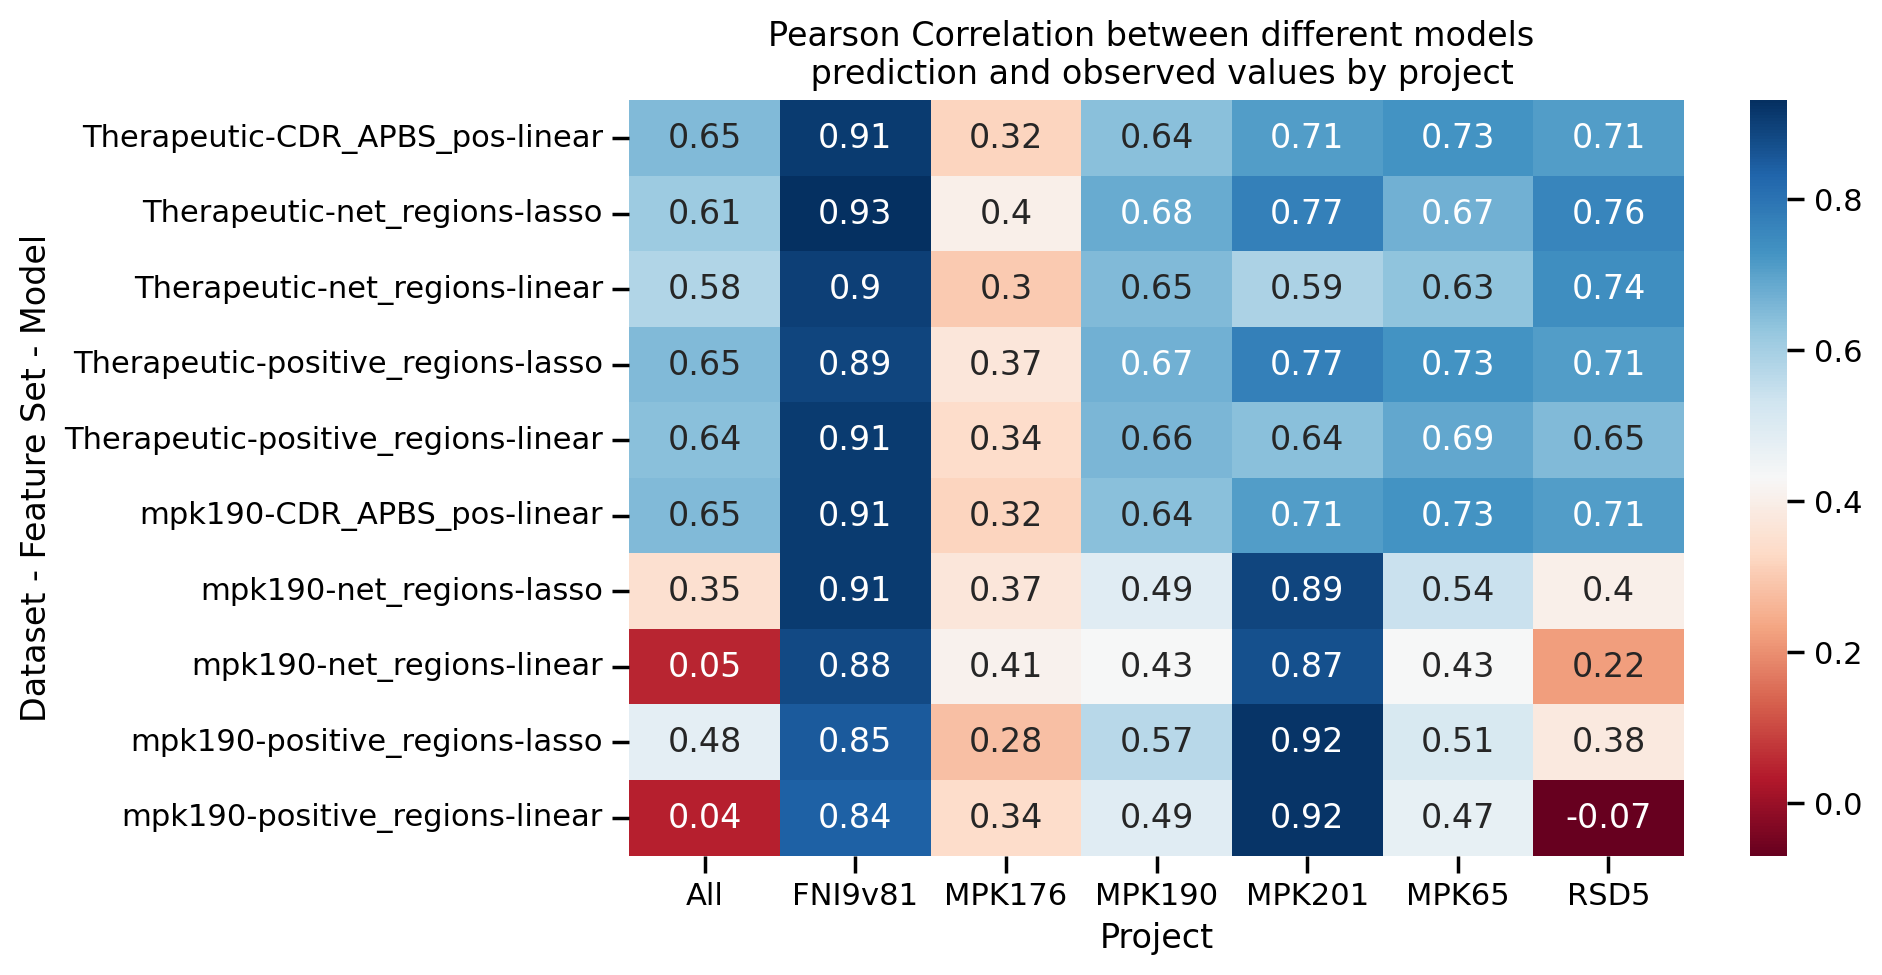

In [37]:
fig, axes = plt.subplots(1, 1, figsize = (10,5))
ax= sns.heatmap(pearson_df, annot=True, cmap ='RdBu')
ax.set(ylabel= 'Dataset - Feature Set - Model', title = 'Pearson Correlation between different models \n prediction and observed values by project')
plt.tight_layout()

<Axes: xlabel='Project', ylabel='dataset-feature_set-model'>

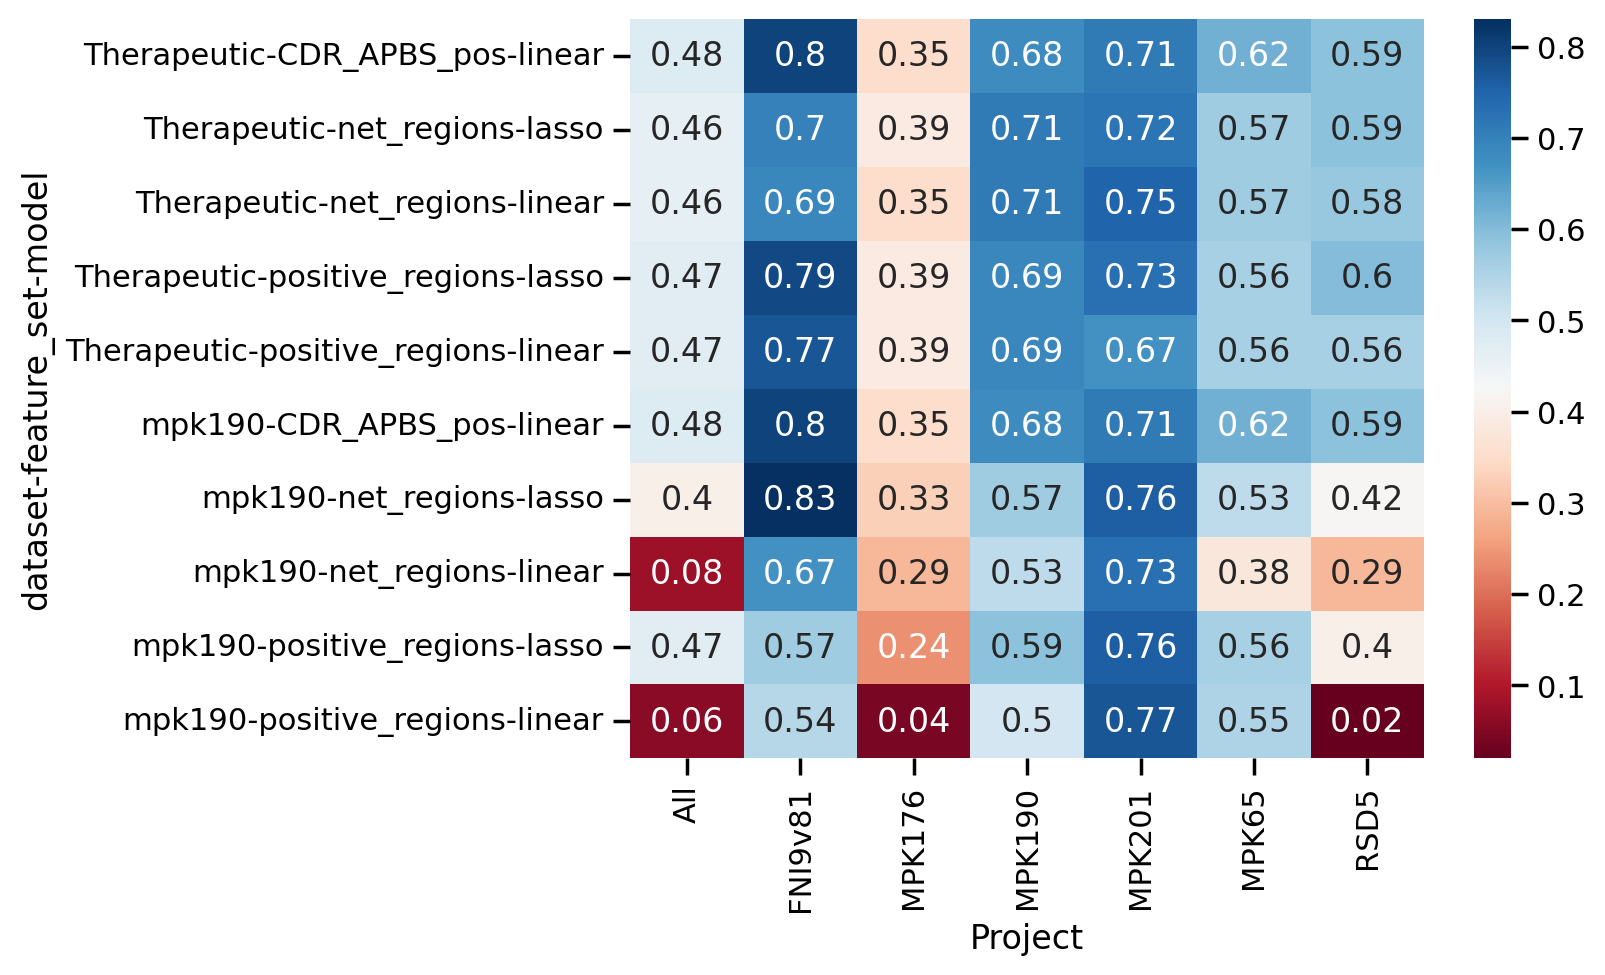

In [38]:
sns.heatmap(spearman_df, annot=True, cmap ='RdBu')

### Is there a relationship between the performance of the linear models and the scalar factor? 
Looking at the heatmaps above, I noted 

In [39]:
Project = "FNI9v81,MPK190,MPK176,MPK65,RSD5,MPK201".split(',')
scaling_factor_df = pd.DataFrame(dict(Project = Project, factor = [1.000,1.084,1.025,0.958,1.005,1.015] ))
scaling_factor_df

Project  factor
0  FNI9v81   1.000
1   MPK190   1.084
2   MPK176   1.025
3    MPK65   0.958
4     RSD5   1.005
5   MPK201   1.015

In [40]:
df = pearson_df.melt(ignore_index=False, value_name = 'Pearson Corr').query('Project!="All"').reset_index()
df =df.merge(scaling_factor_df)
df['factor_diff'] = (df['factor']-1).abs()
show(df)


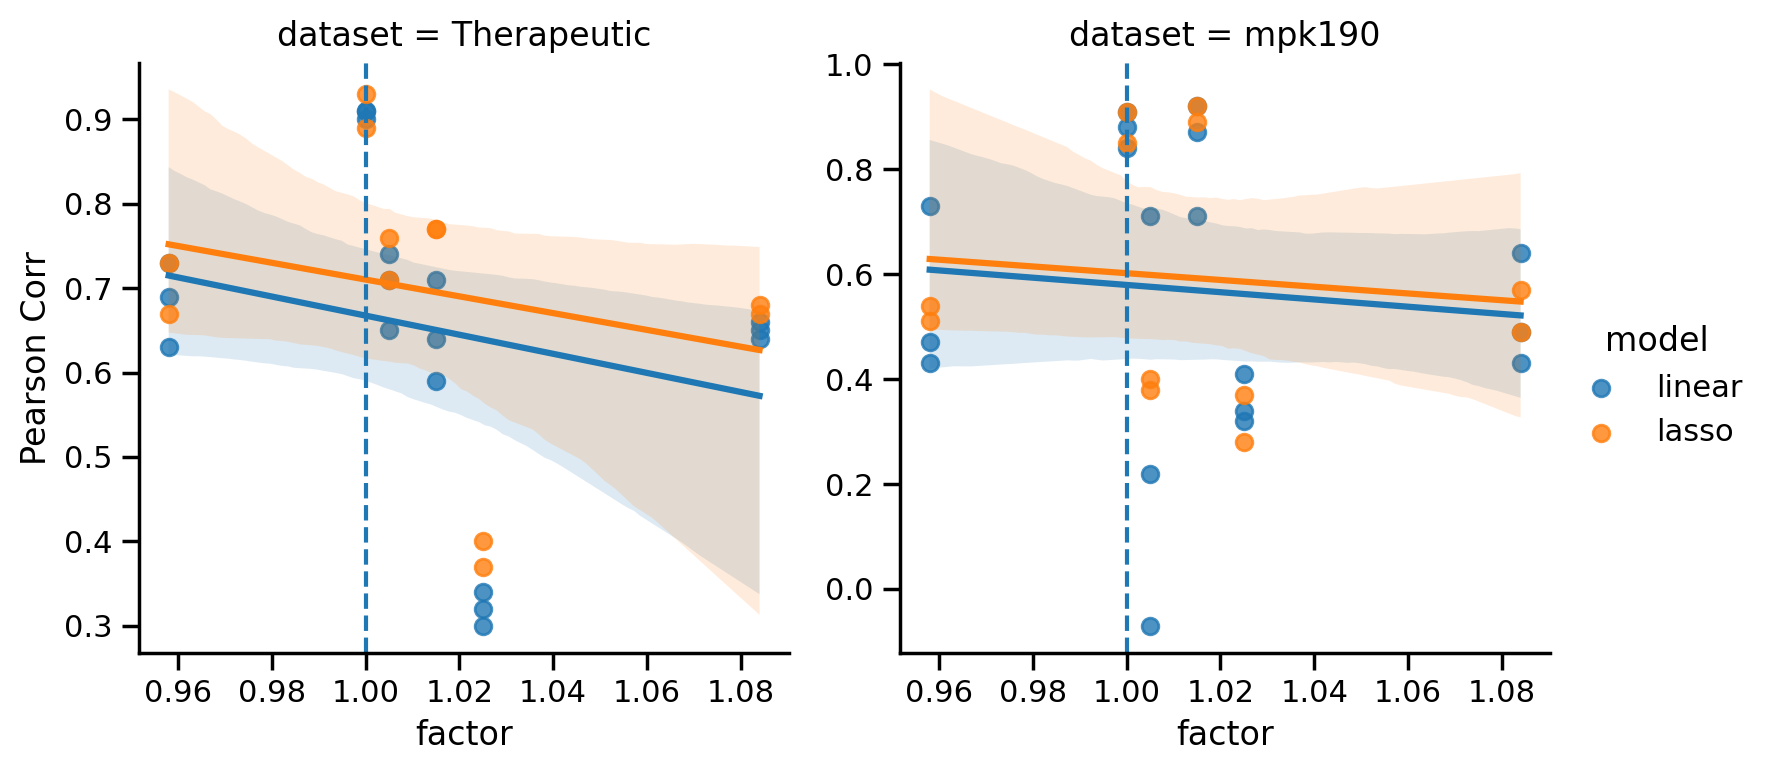

In [41]:
g = sns.lmplot(data=df,x='factor',y='Pearson Corr', hue='model', col ='dataset', facet_kws=dict(sharey=False), height = 4)
for ax in g.axes.flat: 
    ax.axvline(1, linestyle='--')



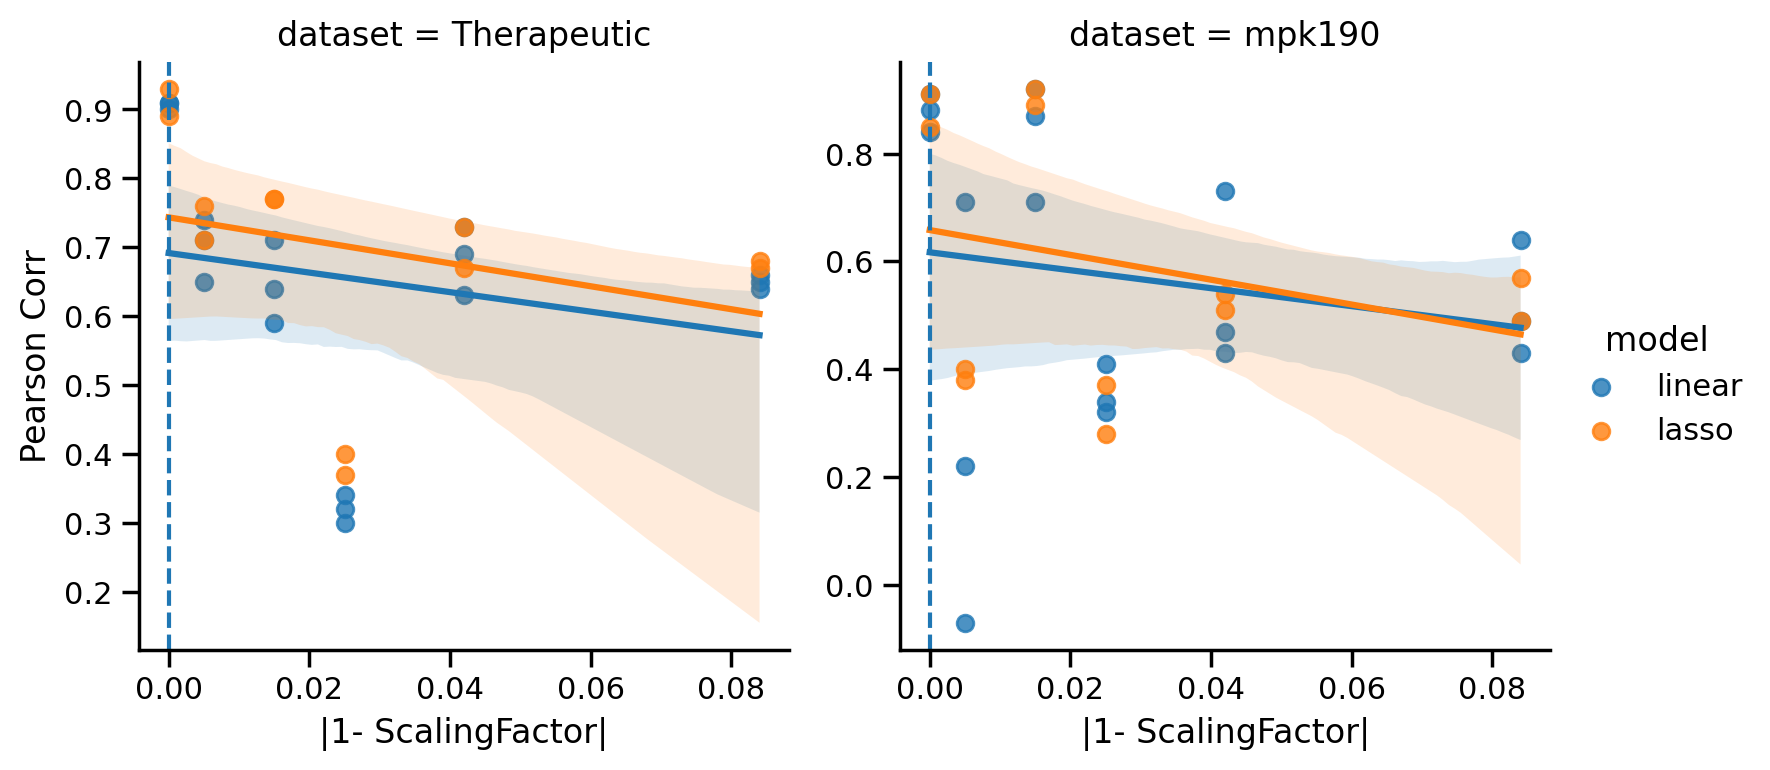

In [42]:
g = sns.lmplot(data=df,x='factor_diff',y='Pearson Corr', hue='model', col ='dataset', facet_kws=dict(sharey=False), height = 4)
for ax in g.axes.flat: 
    ax.axvline(0, linestyle='--')
    ax.set(xlabel=r'|1- ScalingFactor|')

In [43]:
df.groupby(['dataset'])[['factor', 'Pearson Corr']].corr()

factor  Pearson Corr
dataset                                        
Therapeutic factor        1.00000      -0.23691
            Pearson Corr -0.23691       1.00000
mpk190      factor        1.00000      -0.09984
            Pearson Corr -0.09984       1.00000

In [44]:
df.groupby(['dataset'])[['factor_diff', 'Pearson Corr']].corr()

factor_diff  Pearson Corr
dataset                                            
Therapeutic factor_diff      1.000000     -0.252476
            Pearson Corr    -0.252476      1.000000
mpk190      factor_diff      1.000000     -0.215508
            Pearson Corr    -0.215508      1.000000

### Comparison of distributions of Heparin RRT

In [45]:
therapeutic_antibodies = pd.read_parquet(training_path/'therapeutic_antibody_descriptor_results.parquet')
mpk190 = pd.read_parquet(training_path/'MPK190_descriptors_05-03-2024.parquet')
multiple_ab_set = (pd.read_parquet(training_path/'Multi_antibody_train_04-26-2024_with_project_names.parquet')
                   .reset_index()
                   .rename(columns = {'index': 'Project'})
                   )
                   

In [46]:
multiple_ab_set.head()

Project  HeparinRRT_scaled  HeparinRRT>=1  HCDR1_APBS_pos  HCDR1_APBS_neg  \
0   MPK65           0.943630              0      514.043614     -226.497693   
1   MPK65           0.944588              0      242.088930     -155.894361   
2   MPK65           0.944588              0      464.560335      -58.598476   
3   MPK65           0.945546              0      291.646471     -147.543778   
4   MPK65           0.945546              0      366.064822     -108.704110   

   HCDR1_APBS_net  HCDR2_APBS_pos  HCDR2_APBS_neg  HCDR2_APBS_net  \
0      287.545921      957.039160    -2774.632167    -1817.593007   
1       86.194569     1144.556373    -2836.386774    -1691.830401   
2      405.961859      865.244076    -2724.851363    -1859.607288   
3      144.102693      820.741610    -2737.173248    -1916.431638   
4      257.360713     1468.203155    -2324.547613     -856.344458   

   HCDR3_APBS_pos  HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  \
0      474.052607   -11631.036286   -11156.983678    9187.473170   
1      241.478273   -11589.613907   -11348.135635    8455.836708   
2      423.496289   -11045.290265   -10621.793976    9069.096991   
3      418.326279   -11228.470281   -10810.144003    9326.261275   
4      377.512744   -11357.946167   -10980.433422    9703.616380   

   HFR1_APBS_neg  HFR1_APBS_net  HFR2_APBS_pos  HFR2_APBS_neg  HFR2_APBS_net  \
0   -1570.692614    7616.780557    2185.065987    -203.909684    1981.156303   
1   -1173.958997    7281.877712    2439.492207    -316.636589    2122.855618   
2   -1690.993550    7378.103440    2381.159008    -213.788903    2167.370104   
3   -1077.094244    8249.167032     373.585959    -904.631815    -531.045856   
4   -1144.026385    8559.589996    2902.108756    -244.230142    2657.878614   

   HFR3_APBS_pos  HFR3_APBS_neg  HFR3_APBS_net  HFR4_APBS_pos  HFR4_APBS_neg  \
0    4158.978221   -1759.852870    2399.125351     772.320449    -949.248069   
1    6257.033415    -286.276976    5970.756439     257.495449    -927.100073   
2    3713.731344   -2169.095956    1544.635388     808.693052   -1036.254124   
3    5655.615450    -298.212578    5357.402871     588.545738    -885.861933   
4    6786.561876    -100.900932    6685.660944     761.538236    -751.449461   

   HFR4_APBS_net  LCDR1_APBS_pos  LCDR1_APBS_neg  LCDR1_APBS_net  \
0    -176.927620      497.569119    -1568.220608    -1070.651489   
1    -669.604624      600.417592    -1436.307811     -835.890219   
2    -227.561072      548.447000    -1413.785404     -865.338404   
3    -297.316195      421.403946    -1570.191750    -1148.787804   
4      10.088775      693.839926    -1396.639095     -702.799170   

   LCDR2_APBS_pos  LCDR2_APBS_neg  LCDR2_APBS_net  LCDR3_APBS_pos  \
0     2535.649024     -371.314366     2164.334658      430.989836   
1     2255.001478     -333.490586     1921.510893      413.984661   
2     2539.518784     -305.141182     2234.377601      546.423271   
3     2487.563063     -391.122694     2096.440369      476.021169   
4     1805.883533     -559.961224     1245.922310      489.324095   

   LCDR3_APBS_neg  LCDR3_APBS_net  LFR1_APBS_pos  LFR1_APBS_neg  \
0     -729.034198     -298.044362    3267.757690   -1719.993507   
1     -705.248976     -291.264315    2982.452006   -2070.164975   
2     -638.265710      -91.842439    3479.121146   -1744.158750   
3     -727.770477     -251.749308    2494.457975   -2282.583853   
4     -631.560859     -142.236764    3623.278379   -1924.117822   

   LFR1_APBS_net  LFR2_APBS_pos  LFR2_APBS_neg  LFR2_APBS_net  LFR3_APBS_pos  \
0    1547.764183    5513.449735     -22.107470    5491.342266    4917.313653   
1     912.287030    2189.138402    -609.270846    1579.867556    3574.310194   
2    1734.962396    5419.619395     -17.908031    5401.711364    4822.124473   
3     211.874121    4551.228647     -33.474826    4517.753821    4311.286793   
4    1699.160557    4772.156701     -29.028735    4743.127966    1996.512878   

   LFR3_APBS_neg  LFR3_APBS_net  

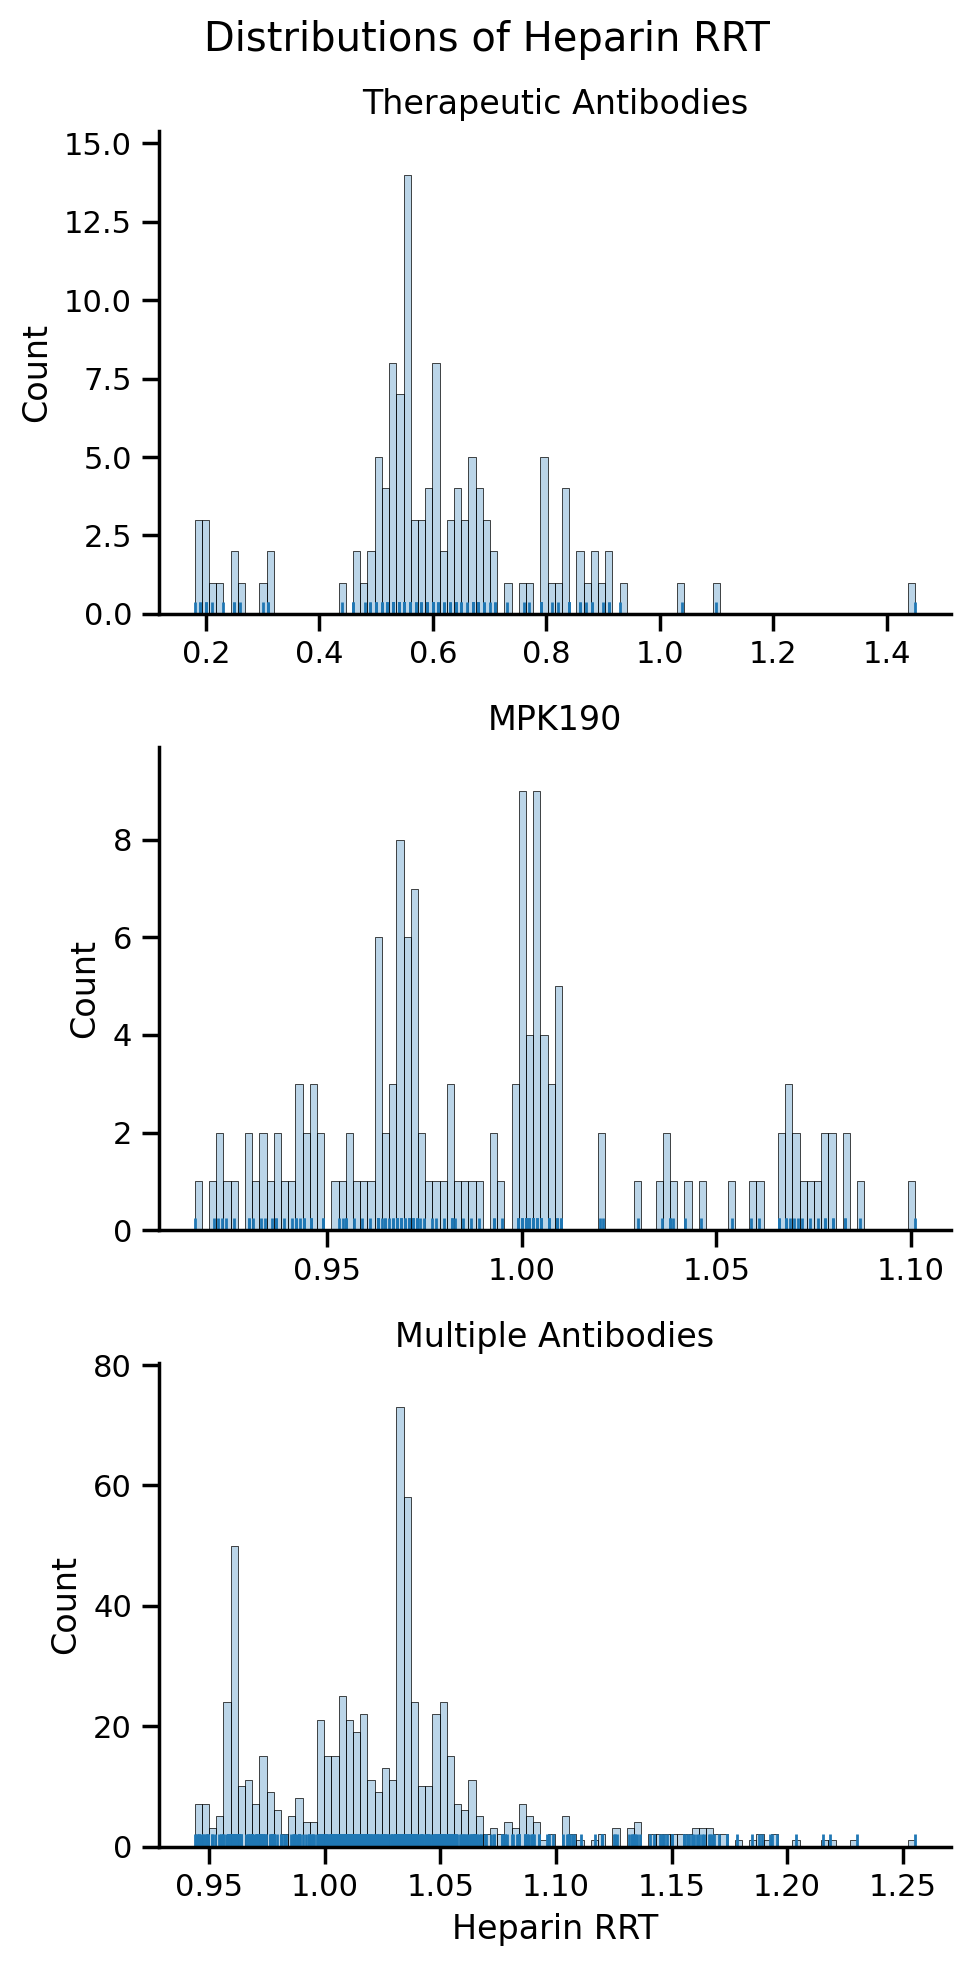

In [47]:
w, h = 5, 10
fig, axes = plt.subplots(3,1, figsize = (w,h))
axes = np.ravel(axes)

xlim = (0, 1.5)

ax = sns.histplot(therapeutic_antibodies['Heparin'], bins = 100, ax = axes[0], alpha = 0.3)
sns.rugplot(therapeutic_antibodies['Heparin'], ax = ax)
ax.set(xlabel = '', title='Therapeutic Antibodies')


ax = sns.histplot(mpk190['Hep RTT'], bins = 100, ax = axes[1], alpha = 0.3)
sns.rugplot(mpk190['Hep RTT'], ax = ax)
ax.set(xlabel = '', title = 'MPK190')

ax = sns.histplot(multiple_ab_set['HeparinRRT_scaled'], bins = 100, ax = axes[2], alpha = 0.3)
sns.rugplot(multiple_ab_set['HeparinRRT_scaled'], ax= ax)
ax.set(xlabel ='Heparin RRT', title = 'Multiple Antibodies')

fig.suptitle('Distributions of Heparin RRT')
sns.despine()
plt.tight_layout()


In [48]:
show(pd.concat([scaling_factor_df.set_index('Project'), project_counts], axis = 1).reset_index())